## Import all the things we need

In [2]:
import time
ts = []
ts.append(time.time())

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as K
import uproot
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

from constants import DSID_Name_mapping, DSID_mass_mapping, SIGNAL_DSIDs, CROSS_SECTION_LIMITS, DSID_TYPE_MAPPING
import matplotlib.pyplot as plt

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

## Read in the data

In [3]:
# Set up some overarching variables, plotting/logging directories, etc.
RAND_STATE = 12345

saveDir = "output/" + datetime.now().strftime("%Y%m%d-%H%M%S")  + "_TrainAndSaveNNsMulticlassNotebook2/"
os.makedirs(saveDir)
print(saveDir)

inv_dsid_mass_map = {v: k for k, v in DSID_mass_mapping.items()}

DIR_PATH="/data/baines/20240516/"
FILE_DSID_MAPPING = {} # Will get filled in later

# Decide which set of ttbar samples to include
ttbar_samples = 'Nominal'
# ttbar_samples = 'Nominal + BFilt'
# ttbar_samples = 'Nominal + HTFilt'
# ttbar_samples = 'Nominal + BFilt + HTFilt'

# Only read in the columns we care about; massively reduces ram requirement if we have big ntuples
cols_to_read = [
    # "runNumber",
    "eventNumber",
    # "eventWeight",
    "DSID",
    "weight_pileup",
    "weight_mc",
    "weight_leptonSF",
    "weight_bTagSF_DL1r_Continuous",
    "weight_jvt",
    "luminosity_factor",
    "weight_normalise",
    "TopHeavyFlavorFilterFlag",
    "GenFiltHT",
    "xsec",
    "kfac",
    "sumOfMCGenWeights",
    "Lepton_M",
    "Lepton_Pt",
    "Lepton_Eta",
    "Lepton_Phi",
    "Neutrino_M",
    "Neutrino_Pt",
    "Neutrino_Eta",
    "Neutrino_Phi",
    "met_met",
    "met_phi",
    "Wlep_M",
    "Wlep_Pt",
    "Wlep_Eta",
    "Wlep_Phi",
    "LJet1_M",
    "LJet1_Pt",
    "LJet1_Eta",
    "LJet1_Phi",
    "LJet1_Dxbb",
    "LJet2_M",
    "LJet2_Pt",
    "LJet2_Eta",
    "LJet2_Phi",
    "LJet2_Dxbb",
    "LJet3_M",
    "LJet3_Pt",
    "LJet3_Eta",
    "LJet3_Phi",
    "LJet3_Dxbb",
    "LJet4_M",
    "LJet4_Pt",
    "LJet4_Eta",
    "LJet4_Phi",
    "LJet4_Dxbb",
    "SJet1_M",
    "SJet1_Pt",
    "SJet1_Eta",
    "SJet1_Phi",
    "SJet1_tagWeightBin_DL1r_Continuous",
    "SJet2_M",
    "SJet2_Pt",
    "SJet2_Eta",
    "SJet2_Phi",
    "SJet2_tagWeightBin_DL1r_Continuous",
    "SJet3_M",
    "SJet3_Pt",
    "SJet3_Eta",
    "SJet3_Phi",
    "SJet3_tagWeightBin_DL1r_Continuous",
    "SJet4_M",
    "SJet4_Pt",
    "SJet4_Eta",
    "SJet4_Phi",
    "SJet4_tagWeightBin_DL1r_Continuous",
    "truth_W_decay_mode",
    "truth_agreement",
    "lep_charge_agreement",
]

output/20240524-175210_TrainAndSaveNNsMulticlassNotebook2/


In [4]:
read_feather = False # If we have this enabled, we'll skip most of read-in and processing in favour of reading a cached version. But need to remove it if we have additional ntuples or input variables

In [5]:
if not read_feather:
    if 1: # Faster, but doesn't work if we have branches in the root file which contain vectors (ie, this only works with flat ntuples)
        all_files = os.listdir(DIR_PATH)
        #dfs_all = {dsid : None for dsid in DSID_Name_mapping}
        dfs_all = {}
        for file_path in all_files:
            if (file_path == "user.rhulsken.mc16_13TeV.407348.aMCNloP8_ttbarHT1k5_nonAH.TOPQ1.e6884a875.allPartsCombined.root"):
                print('Skipping sample: %s' %(file_path))
                continue
            if (file_path == "user.rhulsken.mc16_13TeV.407349.aMCNloP8_ttbarHT1k_1k5_nonAH.TOPQ1.e6884a875.allPartsCombined.root"):
                print('Skipping sample: %s' %(file_path))
                continue
            if ((ttbar_samples == 'Nominal') & ((file_path.startswith('user.rhulsken.mc16_13TeV.40734')) | (file_path.startswith('user.rhulsken.mc16_13TeV.41107')))):
                print('Skipping sample: %s because we are using the %s ttbar samples' %(file_path, ttbar_samples))
                continue
            if ((ttbar_samples == 'Nominal + BFilt') & (file_path.startswith('user.rhulsken.mc16_13TeV.40734'))):
                print('Skipping sample: %s because we are using the %s ttbar samples' %(file_path, ttbar_samples))
                continue
            if ((ttbar_samples == 'Nominal + HTFilt') & (file_path.startswith('user.rhulsken.mc16_13TeV.41107'))):
                print('Skipping sample: %s because we are using the %s ttbar samples' %(file_path, ttbar_samples))
                continue
            if (file_path.startswith('user.rhulsken.mc16_13TeV.410654.PoPy8_WtDS')):
                print('Skipping sample: %s because we are using the diagram removal scheme for single top' %(file_path))
                continue
            if (file_path.startswith('user.rhulsken.mc16_13TeV.410655.PoPy8_WtDS')):
                print('Skipping sample: %s because we are using the diagram removal scheme for single top' %(file_path))
                continue
            #print(DIR_PATH+file_path)
            # For now, just do one signal and background
            # if (not ((file_path.startswith("user.rhulsken.mc16_13TeV.410470.")) or (file_path.startswith("user.rhulsken.mc16_13TeV.510120.")))):
            # if (not ((file_path.startswith("user.rhulsken.mc16_13TeV.700320.")) or (file_path.startswith("user.rhulsken.mc16_13TeV.510120.")))):
            #     continue
            print("Opening file: %s" %(file_path))
            with uproot.open(DIR_PATH+file_path) as rootf:
                # tmp_df = rootf["tree"].arrays(list(eventfeatures_dict.keys()), library='pandas')
                tmp_df = rootf["tree"].arrays(cols_to_read, library='pandas')
                tmp_df = tmp_df.copy()
                if len(tmp_df) > 0:
                    dsid = tmp_df["DSID"][0]
                    print("File has length: %d, dsid: %s" %(len(tmp_df), dsid))
                    FILE_DSID_MAPPING[file_path] = str(dsid)
                else:
                    continue
                dfs_all[str(dsid)] = tmp_df
        ks = list(dfs_all.keys())
        inv_map = {v: k for k, v in FILE_DSID_MAPPING.items()}

Opening file: user.rhulsken.mc16_13TeV.700322.Sh_2211_Zee_maxHTpTV2CVBV.TOPQ1.e8351s3126.allPartsCombined.root
File has length: 4303, dsid: 700322
Opening file: user.rhulsken.mc16_13TeV.363355.She221_ZqqZvv.TOPQ1.e5525s3126.allPartsCombined.root
Opening file: user.rhulsken.mc16_13TeV.410647.PoPy8_Wt_DR_inclusive_tbar.TOPQ1.e6552s3126.allPartsCombined.root
File has length: 87221, dsid: 410647
Opening file: user.rhulsken.mc16_13TeV.510123.MGPy8EGNNPDF30_Hp_H2500_Whbb.TOPQ1.e8448s3126.allPartsCombined.root
File has length: 310085, dsid: 510123
Opening file: user.rhulsken.mc16_13TeV.510116.MGPy8EGNNPDF30_Hp_H900_Whbb.TOPQ1.e8448s3126.allPartsCombined.root
File has length: 290724, dsid: 510116
Opening file: user.rhulsken.mc16_13TeV.363360.She221_WplvWmqq.TOPQ1.e5983s3126.allPartsCombined.root
File has length: 1219, dsid: 363360
Opening file: user.rhulsken.mc16_13TeV.363359.She221_WpqqWmlv.TOPQ1.e5583s3126.allPartsCombined.root
File has length: 2190, dsid: 363359
Skipping sample: user.rhulsk

In [6]:
# Calculate the event weight (taking into account which ttbar samples are included)
if not read_feather:
    for dsid in sorted(dfs_all.keys()):
        dfs_all[dsid]['eventWeight'] = dfs_all[dsid]['weight_normalise'] * dfs_all[dsid]['weight_pileup'] * dfs_all[dsid]['weight_mc'] * dfs_all[dsid]['weight_leptonSF'] * dfs_all[dsid]['weight_bTagSF_DL1r_Continuous'] * dfs_all[dsid]['weight_jvt'] * dfs_all[dsid]['luminosity_factor']
        non_ttbar_filter = (~(dfs_all[dsid]['DSID']==410470).astype(bool))
        for dsid_i in [411073, 411074, 411075, 411076, 411077, 411078, 407342, 407343, 407344]:
            non_ttbar_filter = non_ttbar_filter & (~(dfs_all[dsid]['DSID']==dsid_i).astype(bool))
        if ttbar_samples == 'Nominal': # just the nominal ttbar samples
            ttbar_filter = (dfs_all[dsid]['DSID']==410470).astype(bool)
        elif ttbar_samples == 'Nominal + HTFilt':
            assert(('407344' in dfs_all.keys()) and ('407343' in dfs_all.keys()) and ('407342' in dfs_all.keys()))
            ttbar_filter = (  ( (dfs_all[dsid]['DSID']==410470) & (dfs_all[dsid]['GenFiltHT']<600000) )  |
                            ( (dfs_all[dsid]['DSID']==407344) & (dfs_all[dsid]['GenFiltHT']>600000) & (dfs_all[dsid]['GenFiltHT']<1000000) ) | 
                            ( (dfs_all[dsid]['DSID']==407343) & (dfs_all[dsid]['GenFiltHT']>1000000) & (dfs_all[dsid]['GenFiltHT']<1500000) ) | 
                            ( (dfs_all[dsid]['DSID']==407342) & (dfs_all[dsid]['GenFiltHT']>1500000)) 
                        )
        elif ttbar_samples == 'Nominal + BFilt': # just the nominal ttbar samples
            assert(('411073' in dfs_all.keys()) and ('411074' in dfs_all.keys())  and ('411075' in dfs_all.keys())  and ('411076' in dfs_all.keys())  and ('411077' in dfs_all.keys())  and ('411078' in dfs_all.keys()) )
            ttbar_filter = (  ( (dfs_all[dsid]['DSID']==410470) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==0) )  |
                            ( (dfs_all[dsid]['DSID']==411073) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==1) )  |
                            ( (dfs_all[dsid]['DSID']==411076) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==1) )  |
                            ( (dfs_all[dsid]['DSID']==411074) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==2) )  |
                            ( (dfs_all[dsid]['DSID']==411077) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==2) )  |
                            ( (dfs_all[dsid]['DSID']==411075) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==3) )  |
                            ( (dfs_all[dsid]['DSID']==411078) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==3) )
            )
        elif ttbar_samples == 'Nominal + BFilt + HTFilt': # just the nominal ttbar samples
            assert(('411073' in dfs_all.keys()) and ('411074' in dfs_all.keys())  and ('411075' in dfs_all.keys())  and ('411076' in dfs_all.keys())  and ('411077' in dfs_all.keys())  and ('411078' in dfs_all.keys()) )
            ttbar_filter = (  ( 
                                ( (dfs_all[dsid]['DSID']==410470) & (dfs_all[dsid]['GenFiltHT']<600000) )  |
                                ( (dfs_all[dsid]['DSID']==407344) & (dfs_all[dsid]['GenFiltHT']>600000) & (dfs_all[dsid]['GenFiltHT']<1000000) ) | 
                                ( (dfs_all[dsid]['DSID']==407343) & (dfs_all[dsid]['GenFiltHT']>1000000) & (dfs_all[dsid]['GenFiltHT']<1500000) ) | 
                                ( (dfs_all[dsid]['DSID']==407342) & (dfs_all[dsid]['GenFiltHT']>1500000)) 
                            ) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==0) |
                            ( (dfs_all[dsid]['DSID']==411073) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==1) )  |
                            ( (dfs_all[dsid]['DSID']==411076) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==1) )  |
                            ( (dfs_all[dsid]['DSID']==411074) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==2) )  |
                            ( (dfs_all[dsid]['DSID']==411077) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==2) )  |
                            ( (dfs_all[dsid]['DSID']==411075) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==3) )  |
                            ( (dfs_all[dsid]['DSID']==411078) & (dfs_all[dsid]['TopHeavyFlavorFilterFlag']==3) )
            )
        else:
            assert(0)
        dfs_all[dsid]['eventWeight'] = dfs_all[dsid]['eventWeight']*(non_ttbar_filter | ttbar_filter).astype(float)

In [7]:
# Decorate with the truth label
if not read_feather:
    for dsid in dfs_all.keys():
        dfs_all[dsid]["dsid"] = dsid
        if int(dsid) in SIGNAL_DSIDs:
            dfs_all[dsid]["truth"] = dfs_all[dsid]['truth_W_decay_mode']
        else:
            dfs_all[dsid]["truth"] = 0*np.ones(len(dfs_all[dsid]))

In [8]:
# Just checks how many events per sample are 0
if not read_feather:
    if 1:
        for dsid in sorted(dfs_all.keys()):
            print('%100s: %10d / %10d = %5.2f%%' % (DSID_Name_mapping[int(dsid)], sum((dfs_all[dsid]['eventWeight']==0).astype(int)), len((dfs_all[dsid]['eventWeight']==0).astype(int)), 100*sum((dfs_all[dsid]['eventWeight']==0).astype(int))/len((dfs_all[dsid]['eventWeight']==0).astype(int))))

                                                                                       She221_ZqqZll:         26 /       5075 =  0.51%
                                                                                       She221_WqqZll:          6 /       2159 =  0.28%
                                                                                     She221_WpqqWmlv:          6 /       2190 =  0.27%
                                                                                     She221_WplvWmqq:          6 /       1219 =  0.49%
                                                                                       She221_WlvZqq:         71 /      32130 =  0.22%
                                                                                   PhPy8EG_ttbar_lep:      16264 /    3479554 =  0.47%
                                                                             PoPy8_Wt_DR_inclusive_t:        430 /      87999 =  0.49%
                                                       

In [9]:
# Check the yields from what we've read in
if not read_feather:
    if 1:
        done = {}
        for dsid in dfs_all.keys():
            # print('%30s: %.2f' % (DSID_Name_mapping[int(dsid)], sum(dfs_all[dsid]['eventWeight'])))
            # sel_cut = dfs_all[dsid]['truth_agreement']==1
            # sel_cut = ((dfs_all[dsid]['truth_W_decay_mode']==2).astype(bool) | (dfs_all[dsid]['truth_W_decay_mode']==1).astype(bool)) | (dfs_all[dsid]['is_signal']==0).astype(bool)
            if int(dsid) in SIGNAL_DSIDs:
                sel_cut = ((dfs_all[dsid]['truth_W_decay_mode']==2).astype(bool) | (dfs_all[dsid]['truth_W_decay_mode']==1).astype(bool))
            else:
                sel_cut = np.ones(len(dfs_all[dsid]))
            # sel_cut = np.ones(len(dfs_all[dsid])).astype(bool)
            if DSID_TYPE_MAPPING[int(dsid)] not in done.keys():
                # print('%30s: %.2f' % (DSID_TYPE_MAPPING[int(dsid)], sum(dfs_all[dsid]['eventWeight'])))
                done[DSID_TYPE_MAPPING[int(dsid)]] = sum(dfs_all[dsid]['eventWeight'][sel_cut])
            else:
                done[DSID_TYPE_MAPPING[int(dsid)]] += sum(dfs_all[dsid]['eventWeight'][sel_cut])
        for k in sorted(done.keys()):
            print('%30s: %.2f' % (k, done[k]))

                     0.8TeV H+: 31599.52
                     0.9TeV H+: 34036.78
                     1.0TeV H+: 36185.36
                     1.2TeV H+: 38115.29
                     1.4TeV H+: 38181.40
                     1.6TeV H+: 38237.83
                     1.8TeV H+: 38180.67
                     2.0TeV H+: 37955.05
                     2.5TeV H+: 36971.13
                     3.0TeV H+: 36935.35
                       Diboson: 994.35
                         Zjets: 4184.97
                    single-top: 21864.58
                         ttbar: 368172.68


In [10]:
# decorate with the sample type
if not read_feather:
    for dsid in dfs_all.keys():
        dfs_all[dsid]["sampleType"] = np.array([DSID_TYPE_MAPPING[int(dsid)] for _ in range(len(dfs_all[dsid]))])

In [11]:
# Define a useful function for if we're doing mass-parametrized NNs
def get_equal_masses_split(all_df, mask):
    '''
    Given a boolean mask which can be applied to a dataframe, get a list of masses which can be applied to the combined dataframe
    such that each background class (determined by variable 'SampleType') will have a mass distribution matching that of the signal samples
    '''
    mask = mask.astype(bool)
    sig_mask = all_df['is_signal'].astype(bool)
    sig_dsids = sorted(pd.unique(all_df['dsid'][sig_mask & mask]))
    all_sig_len = sum(sig_mask & mask)
    cumulative_sig_percent = 0
    cumulative_sig_percents = []
    tmp_masses = np.zeros(len(all_df))
    masses = [DSID_mass_mapping[dsid] for dsid in sig_dsids]
    if len(masses) == 1: # If we don't cover this now, we get an error later which is annoying
        tmp_masses = np.ones(len(all_df))*masses[0]
        return tmp_masses
    for dsid in sig_dsids:
        cumulative_sig_percent += sum(all_df['dsid'][mask] == str(dsid))/all_sig_len
        cumulative_sig_percents.append(cumulative_sig_percent)
        tmp_masses[(all_df['dsid']==dsid).astype(bool) & mask & sig_mask] = DSID_mass_mapping[dsid] # In theory, shouldn't really need to do this. Also shouldn't need the sig_mask
    #raise("You're up to here! Have a nice evening! Get some sleep too")
    bkg_classes = sorted(pd.unique(all_df['sampleType'][mask & ~sig_mask]))
    for bkgClass in bkg_classes:
        cumulative_lens = [int(pct*sum(all_df['sampleType'][mask]==bkgClass)) for pct in cumulative_sig_percents[:-1]]
        cumulative_lens = [0] + cumulative_lens
        tmp_masses_subset = -np.ones(len(all_df))
        bkgClass_inds = np.nonzero(np.asarray(all_df['sampleType']==bkgClass) & np.array(mask, dtype=bool))[0]
        for mass_n, mass_val in enumerate(masses[:-1]):
            tmp_masses_subset[bkgClass_inds[cumulative_lens[mass_n]:cumulative_lens[mass_n+1]]] = masses[mass_n]
        tmp_masses_subset[bkgClass_inds[cumulative_lens[mass_n+1]:]] = masses[mass_n+1]
        tmp_masses[bkgClass_inds] = tmp_masses_subset[bkgClass_inds]
    return tmp_masses

In [12]:
# Concatenate the sample dataframes together into one big df
if not read_feather:
    ts.append(time.time())
    print("Time till now: " + str(ts[-1] - ts[-2]))
    #DROPOUT_mass_STR = "504567"
    all_keys = sorted(list(dfs_all.keys()))
    try:
        all_keys.remove('0')
    except:
        print("No data, or data already removed")
    all_df = pd.concat([dfs_all[dsid] for dsid in all_keys], axis=0)
    ts.append(time.time())
    print("Time to concatenate: " + str(ts[-1] - ts[-2]))
    all_df.reset_index(inplace=True)
    ts.append(time.time())
    print("Time to reset_index: " + str(ts[-1] - ts[-2]))
    del dfs_all
    ts.append(time.time())
    print("Time to combine dfs: " + str(ts[-1] - ts[-2]))

Time till now: 234.85634231567383
No data, or data already removed
Time to concatenate: 2.9453654289245605
Time to reset_index: 0.061960697174072266
Time to combine dfs: 0.12209033966064453


In [13]:
# Shuffle the data
ts.append(time.time())
if not read_feather:
    all_df = all_df.sample(frac=1, random_state=RAND_STATE)
ts.append(time.time())
print("Time to shuffle: " + str(ts[-1] - ts[-2]))

Time to shuffle: 12.843156099319458


In [15]:
# Store the data in our 'cache', or read it if we are not processing
if not read_feather:
    # all_df.reset_index(inplace=True)
    #all_df.to_csv('tmp/tmp.csv')
    # all_df.to_feather('tmp/tmpMulticlass.feather')
    all_df.to_pickle('tmp/tmpMulticlassAll.pkl')
else:
    # all_df = pd.read_feather('tmp/tmpMulticlass.feather')
    all_df = pd.read_pickle('tmp/tmpMulticlassAll.pkl')

In [16]:
# What percentage of samples selected are signal but unlabelled
sel = (all_df['dsid'].astype(int) > 500000).astype(bool) & (all_df['dsid'].astype(int) < 600000).astype(bool) & (all_df['truth_agreement'] == 1).astype(bool) & (all_df['truth'] == 0).astype(bool)
sum(sel)/len(sel)*100

0.0843327150339961

In [17]:
# Now throw out events where we aren't certain about truth info
if 1:
    sig_sel = (all_df['dsid'].astype(int) > 500000).astype(bool) & (all_df['dsid'].astype(int) < 600000).astype(bool)
    len_bef = len(all_df)
    good_truth_sel = (all_df['truth_agreement'] == 1).astype(bool) | (~sig_sel)
    len_aft = sum(good_truth_sel)
    print('Removals for good truth agreement in signal samples: %10d / %10d = %5.2f%%' % (len_bef-len_aft, len_bef, 100*(len_bef-len_aft)/len_bef))
    
    well_defined_variables_sel = np.ones(len(all_df)) # Taken this out for this set of ntuples, but may replace later so leaving the variable for now

    # Define the selection for which we will consider variables for training
    train_sel = well_defined_variables_sel & good_truth_sel
    # And for predicting (note, we can't use truth info in the signal samples for this (for the purposes of checking expected yields in different regions) since when we apply to data, we won't have this truth info)
    pred_sel = well_defined_variables_sel.astype(bool)

Removals for good truth agreement in signal samples:     305892 /    9010738 =  3.39%


In [19]:
# Fill with a temporary version of 'truth mass' for doing parametrized networks
if 0:
    all_df['mass'] = get_equal_masses_split(all_df, np.ones(len(all_df)))

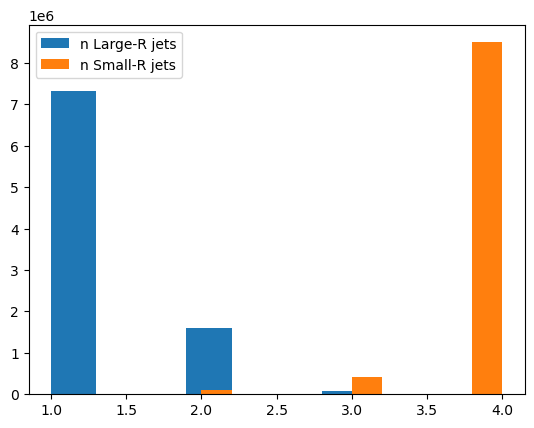

In [20]:
# Add a 'number of jets' variable for both small-R and large-R jets
nJets = np.zeros(len(all_df))
for jetn in [1,2,3,4]:
    plotVar = 'LJet%d_M' %(jetn)
    nJets += (all_df[plotVar] != 0).astype(int)
plt.hist(nJets, label='n Large-R jets')
all_df['NLJets'] = nJets

nJets = np.zeros(len(all_df))
for jetn in [1,2,3,4]:
    plotVar = 'SJet%d_M' %(jetn)
    nJets += (all_df[plotVar] != 0).astype(int)
plt.hist(nJets, label='n Small-R jets')
plt.legend()
all_df['NSJets'] = nJets

In [21]:
# Split into train/val/test sets
# Also produce 'training sample weights' which 1) are all positive 2) respect the relative sizes within each process and 3) respect the original proporions of the Standard Model processes to the overall background
kfold_indices = []
nfolds = 2
inv_val_proportion = 5
for fold_n in range(nfolds):
    print('-------------------------------------------------------------------------------------------------' )
    print('-------------------------------------------  Fold %d  -------------------------------------------' %(fold_n))
    print('-------------------------------------------------------------------------------------------------' )
    overall_masks_dict = {}
    # Train split
    overall_masks_dict['train'] = train_sel & np.asarray(all_df['eventNumber'] % nfolds != fold_n).astype(bool) & np.asarray(all_df['eventNumber'] % inv_val_proportion != 0).astype(bool)
    # Val split
    overall_masks_dict['val'] = train_sel & np.asarray(all_df['eventNumber'] % nfolds != fold_n).astype(bool) & np.asarray(all_df['eventNumber'] % inv_val_proportion == 0).astype(bool)
    # Test split
    overall_masks_dict['test'] = train_sel & np.asarray(all_df['eventNumber'] % nfolds == fold_n).astype(bool)
    if nfolds == 1: # Special case where we only train one fold (SHOULDN'T BE USED IN REALITY; JUST FOR TESTING!)
        print("WARNING: Only using one fold, so using whole dataset for training/validation")
        overall_masks_dict['train'] = train_sel & np.asarray(all_df['eventNumber'] % nfolds != 0.1).astype(bool) & np.asarray(all_df['eventNumber'] % inv_val_proportion != 0).astype(bool)
        overall_masks_dict['val'] = train_sel & np.asarray(all_df['eventNumber'] % nfolds != 0.1).astype(bool) & np.asarray(all_df['eventNumber'] % inv_val_proportion == 0).astype(bool)
        overall_masks_dict['test'] = np.zeros(len(all_df)).astype(bool)
    kfold_indices.append(overall_masks_dict)
    # all_df[model_basename + 'holdout_fold'][pass_train_cut & kfold_indices[-1]['test']] = fold_n


    # Now populate the neural network training weights
    all_df['NN_training_weights_fold_%d' %(fold_n)] = np.zeros(len(all_df))

    y_train = all_df['truth'][kfold_indices[fold_n]['train']].astype(int)
    wts_train = np.abs(all_df['eventWeight'][kfold_indices[fold_n]['train']].astype(float))
    y_val = all_df['truth'][kfold_indices[fold_n]['val']].astype(int)
    wts_val = np.abs(all_df['eventWeight'][kfold_indices[fold_n]['val']].astype(float))
    y_test = all_df['truth'][kfold_indices[fold_n]['test']].astype(int)
    wts_test = np.abs(all_df['eventWeight'][kfold_indices[fold_n]['test']].astype(float))

    if 0: # old method
      # Normalise the weights such that sig and background are equal
      sig_sel = (y_train != 0).astype(bool)
      wts_train[sig_sel] *= sum(wts_train[~sig_sel]) / sum(wts_train[sig_sel])# * 0.2
      sig_sel = (y_val != 0).astype(bool)
      wts_val[sig_sel] *= sum(wts_val[~sig_sel]) / sum(wts_val[sig_sel])# * 0.2
    else:
      # Sort out the weights per sample set
      for set_name, set_y, set_wts in zip(['train', 'val', 'test'], [y_train, y_val, y_test], [wts_train, wts_val, wts_test]):
        print('Set: %s' %(set_name))
        # First, background. We reweight per sample type so that we get the right proportional contribution from each DSID (post absolute).
        pre_absoluteing_contributions = {}
        post_absoluteing_contributions = {}
        for dsid in pd.unique(all_df['dsid'][kfold_indices[fold_n][set_name]]):
          pre_absoluteing_contributions[dsid] = sum(all_df['eventWeight'][kfold_indices[fold_n][set_name] & (all_df['dsid'] == dsid)].astype(float))
          post_absoluteing_contributions[dsid] = sum(set_wts[all_df['dsid'][kfold_indices[fold_n][set_name]] == dsid])
          print ('DSID: %s; pre: %.5f; post: %.5f' %(dsid, pre_absoluteing_contributions[dsid], post_absoluteing_contributions[dsid]))
          if int(dsid) in SIGNAL_DSIDs:
            pass
          else:
            try: 
              set_wts[all_df['dsid'][kfold_indices[fold_n][set_name]] == dsid] *= pre_absoluteing_contributions[dsid] / post_absoluteing_contributions[dsid]
            except ZeroDivisionError:
              print("Sum of absolute weights for dsid %s is zero so skipping the reweighting" %(dsid))
        # Now, signal. We divide each sample by the total for that sample, then divide by num_nonzero sigs and multiply by the total for background
        # sum_bkg_contributions_pre  = sum(pre_absoluteing_contributions[dsid] for dsid in pre_absoluteing_contributions.keys() if ~(dsid in SIGNAL_DSIDs))
        sum_bkg_contributions_pre  = sum(pre_absoluteing_contributions[dsid] for dsid in pre_absoluteing_contributions.keys() if not (int(dsid) in SIGNAL_DSIDs))
        # print(sum_bkg_contributions_pre)
        num_nonzero_sigs = sum(post_absoluteing_contributions[dsid] > 0 for dsid in post_absoluteing_contributions.keys() if (int(dsid) in SIGNAL_DSIDs))
        print('Num nonzero signal samples: %s' %(num_nonzero_sigs))
        for dsid in pd.unique(all_df['dsid'][kfold_indices[fold_n][set_name]]):
          if int(dsid) in SIGNAL_DSIDs:
            set_wts[all_df['dsid'][kfold_indices[fold_n][set_name]] == dsid] *= sum_bkg_contributions_pre / post_absoluteing_contributions[dsid] / num_nonzero_sigs
          else:
            pass
        print('------------------------------------------------------------')
        if 0: # Just view some of the weights
          for dsid in pd.unique(all_df['dsid'][kfold_indices[fold_n][set_name]]):
              plt.figure(figsize=(4,2))
              plt.hist(all_df['eventWeight'][kfold_indices[fold_n][set_name] & (all_df['dsid'] == dsid)].astype(float))
              plt.yscale('log')
              plt.title(dsid)
              plt.show()
        all_df.loc[kfold_indices[fold_n][set_name], 'NN_training_weights_fold_%d' %(fold_n)] = set_wts



    for target in [0,1,2]:
        print('Target: %d train prop = %5.2f%% (%5.2f%%)' %(target, sum(y_train==target)/len(y_train)*100, sum(wts_train[y_train==target])/sum(wts_train)*100))
        print('Target: %d val   prop = %5.2f%% (%5.2f%%)' %(target, sum(y_val==target)/len(y_val)*100, sum(wts_val[y_val==target])/sum(wts_val)*100))
        print('Target: %d test   prop = %5.2f%% (%5.2f%%)' %(target, sum(y_test==target)/len(y_test)*100, sum(wts_test[y_test==target])/sum(wts_test)*100))

-------------------------------------------------------------------------------------------------
-------------------------------------------  Fold 0  -------------------------------------------
-------------------------------------------------------------------------------------------------
Set: train
DSID: 510120; pre: 15331.18624; post: 56184.29381
DSID: 410470; pre: 169495.97133; post: 173104.22089
DSID: 700320; pre: 304.13184; post: 540.37849
DSID: 700323; pre: 187.29095; post: 328.55951
DSID: 410647; pre: 4007.84974; post: 4087.04464
DSID: 510122; pre: 14855.85071; post: 55201.44678
DSID: 510118; pre: 15126.73888; post: 55346.74659
DSID: 363489; pre: 488.78036; post: 579.10822
DSID: 700321; pre: 56.00257; post: 100.65880
DSID: 510115; pre: 12349.17981; post: 46616.13849
DSID: 510119; pre: 15055.99872; post: 55734.31086
DSID: 510117; pre: 14481.24776; post: 53489.35091
DSID: 510121; pre: 14916.95115; post: 55563.60751
DSID: 510123; pre: 14655.64672; post: 54215.50356
DSID: 510116;

In [22]:
# Check if the proportions of each class in train/val/test are ~equal. Note, we care about the *weighted* proportions (those in brackets)
for target in [0,1,2]:
    print('Target: %d train prop = %5.2f%% (%5.2f%%)' %(target, sum(y_train==target)/len(y_train)*100, sum(wts_train[y_train==target])/sum(wts_train)*100))
    print('Target: %d val   prop = %5.2f%% (%5.2f%%)' %(target, sum(y_val==target)/len(y_val)*100, sum(wts_val[y_val==target])/sum(wts_val)*100))
    print('Target: %d test  prop = %5.2f%% (%5.2f%%)' %(target, sum(y_test==target)/len(y_test)*100, sum(wts_test[y_test==target])/sum(wts_test)*100))
    print('--------------------------------------------------')

Target: 0 train prop = 68.34% (50.14%)
Target: 0 val   prop = 68.44% (50.13%)
Target: 0 test  prop = 68.35% (50.14%)
--------------------------------------------------


Target: 1 train prop = 19.31% (30.33%)
Target: 1 val   prop = 19.26% (30.32%)
Target: 1 test  prop = 19.33% (30.36%)
--------------------------------------------------
Target: 2 train prop = 12.34% (19.53%)
Target: 2 val   prop = 12.30% (19.55%)
Target: 2 test  prop = 12.32% (19.50%)
--------------------------------------------------


In [23]:
# Define the list of variables that we'll be using as inputs
base_inputs = [
       # 'Lepton_M', 'Lepton_Pt', 'Lepton_Eta', 'Lepton_Phi', 
       # 'Neutrino_M', 'Neutrino_Pt', 'Neutrino_Eta', 'Neutrino_Phi', 
       # 'met_met', 'met_phi', 
       'Wlep_M', 'Wlep_Pt', 'Wlep_Eta', 'Wlep_Phi', 
       'LJet1_M', 'LJet1_Pt', 'LJet1_Eta', 'LJet1_Phi', #'LJet1_Dxbb', 
       'LJet2_M', 'LJet2_Pt', 'LJet2_Eta', 'LJet2_Phi', #'LJet2_Dxbb', 
       'LJet3_M', 'LJet3_Pt', 'LJet3_Eta', 'LJet3_Phi', #'LJet3_Dxbb', 
       'LJet4_M', 'LJet4_Pt', 'LJet4_Eta', 'LJet4_Phi', #'LJet4_Dxbb', 
       'SJet1_M', 'SJet1_Pt', 'SJet1_Eta', 'SJet1_Phi', 'SJet1_tagWeightBin_DL1r_Continuous', 
       'SJet2_M', 'SJet2_Pt', 'SJet2_Eta', 'SJet2_Phi', 'SJet2_tagWeightBin_DL1r_Continuous', 
       'SJet3_M', 'SJet3_Pt', 'SJet3_Eta', 'SJet3_Phi', 'SJet3_tagWeightBin_DL1r_Continuous',
       'SJet4_M', 'SJet4_Pt', 'SJet4_Eta', 'SJet4_Phi', 'SJet4_tagWeightBin_DL1r_Continuous', 
       'NSJets', 'NLJets',
]

In [32]:
# Make the models and fit history dictionaries
if not ('models' in globals()):
  models = {}
  fit_histories = {}
  model_n = 0
else:
  model_n += 1

In [33]:
class ROCAUCMetric(tf.keras.metrics.Metric):
    def __init__(self, name='roc_auc', num_classes=3, target_class=0, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.target_class = target_class
        self.roc_auc = self.add_weight(name=name, initializer='zeros', dtype=tf.double)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.double)
        y_pred = tf.nn.softmax(y_pred, axis=-1)

        # for i in range(self.num_classes):
        for i in [self.target_class]:
            y_true_class = tf.cast(tf.equal(y_true, i), tf.int32)
            y_pred_class = y_pred[:, i]
            if sample_weight is None:
              roc_auc = tf.numpy_function(
                              lambda y_true, y_pred: roc_auc_score(y_true, y_pred),
                              [y_true_class, y_pred_class],
                              tf.double
                          )
            else:
              roc_auc = tf.numpy_function(
                              lambda y_true, y_pred, sample_wt: roc_auc_score(y_true, y_pred, sample_weight=sample_wt),
                              [y_true_class, y_pred_class, sample_weight],
                              tf.double
                          )
            self.roc_auc.assign(roc_auc)

    def result(self):
        return self.roc_auc

    def reset_state(self):
        self.roc_auc.assign(0.)

In [34]:
# Make the models and fit history dictionaries
if not ('models' in globals()):
  models = {}
  fit_histories = {}
  model_n = 0
else:
  model_n += 1

# Create a new model
fold_n = 0
if 0:
  inputs = base_inputs[:-2] # Exclude the njets variables
  batch_size=1024
  n_epochs=20
  layers=[
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
    ]
  learning_rate=1e-5
elif 0: # ??
  inputs = base_inputs
  batch_size=1024
  n_epochs=10
  layers=[
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5)),
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5)),
          # tf.keras.layers.Dropout(0.005),
          tf.keras.layers.Dense(3)
          ]
  learning_rate=2e-6
elif 1: # ??
  inputs = base_inputs
  batch_size=1024
  n_epochs=5
  layers=[
          # tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(512, activation='relu'),
          # tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(3)
          ]
  learning_rate=1e-7
  def scheduler(epoch, lr):
    return lr * 0.92
  lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)
  


roc_auc_metric = ROCAUCMetric(num_classes=3)
roc_auc_metric2 = ROCAUCMetric(num_classes=3)
roc_auc_metric_lvbb = ROCAUCMetric(num_classes=3,target_class=1,name='roc_auc_lvbb')
roc_auc_metric2_lvbb = ROCAUCMetric(num_classes=3,target_class=1,name='roc_auc_lvbb')
roc_auc_metric_qqbb = ROCAUCMetric(num_classes=3,target_class=2,name='roc_auc_qqbb')
roc_auc_metric2_qqbb = ROCAUCMetric(num_classes=3,target_class=2,name='roc_auc_qqbb')
models[model_n] = {'model' : tf.keras.Sequential(layers), 'inputs' : inputs}
models[model_n]['model'].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',roc_auc_metric, roc_auc_metric_lvbb, roc_auc_metric_qqbb],
              weighted_metrics=['accuracy',roc_auc_metric2, roc_auc_metric2_lvbb, roc_auc_metric2_qqbb],
)

# Split into training/validation sets

x_train = all_df[inputs][kfold_indices[fold_n]['train']].astype(float)
y_train = all_df['truth'][kfold_indices[fold_n]['train']].astype(int)
wts_train = all_df['NN_training_weights_fold_%d' %(fold_n)][kfold_indices[fold_n]['train']].astype(float)
x_val = all_df[inputs][kfold_indices[fold_n]['val']].astype(float)
y_val = all_df['truth'][kfold_indices[fold_n]['val']].astype(int)
wts_val = all_df['NN_training_weights_fold_%d' %(fold_n)][kfold_indices[fold_n]['val']].astype(float)

In [35]:
# Actually train the model!
print('About to train model: %d' %(model_n))
models[model_n]['history'] = models[model_n]['model'].fit(x_train, y_train, sample_weight=wts_train,
            epochs=n_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val, wts_val),
            callbacks=[lr_scheduler],
            # class_weight=class_weights,
            # verbose=2,
          )

About to train model: 1
Epoch 1/5
3399/3399 [==============================] - 116s 34ms/step - loss: 241.7959 - accuracy: 0.4361 - roc_auc: 0.6394 - roc_auc_lvbb: 0.7647 - roc_auc_qqbb: 0.6976 - weighted_accuracy: 0.4637 - weighted_roc_auc: 0.6590 - weighted_roc_auc_lvbb: 0.7613 - weighted_roc_auc_qqbb: 0.7312 - val_loss: 106.8401 - val_accuracy: 0.5369 - val_roc_auc: 0.6172 - val_roc_auc_lvbb: 0.7461 - val_roc_auc_qqbb: 0.7093 - val_weighted_accuracy: 0.5892 - val_weighted_roc_auc: 0.6441 - val_weighted_roc_auc_lvbb: 0.7368 - val_weighted_roc_auc_qqbb: 0.7577 - lr: 9.2000e-08
Epoch 2/5
3399/3399 [==============================] - 112s 33ms/step - loss: 76.3350 - accuracy: 0.5981 - roc_auc: 0.6984 - roc_auc_lvbb: 0.8038 - roc_auc_qqbb: 0.7511 - weighted_accuracy: 0.6592 - weighted_roc_auc: 0.7382 - weighted_roc_auc_lvbb: 0.7900 - weighted_roc_auc_qqbb: 0.8127 - val_loss: 55.0794 - val_accuracy: 0.6416 - val_roc_auc: 0.6970 - val_roc_auc_lvbb: 0.8105 - val_roc_auc_qqbb: 0.7248 - val_we

In [36]:
# Print the number of parameters, samples and input variables
for model_num in models.keys():
    print("Model %d" %(model_num))
    model = models[model_num]['model']
    trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    print('Trainable: ', trainable_params, end='')
    print('\tNon trainable: ', non_trainable_params, end='')
    print('\tTotal: ', total_params, end='')
    print('\t\tSamples x train: ', len(x_train), end='')
    print('\tinputs x train: ', len(models[model_num]['inputs']))

Model 1
Trainable:  311043	Non trainable:  0.0	Total:  311043.0		Samples x train:  3480492	inputs x train:  42


FAILED model 1


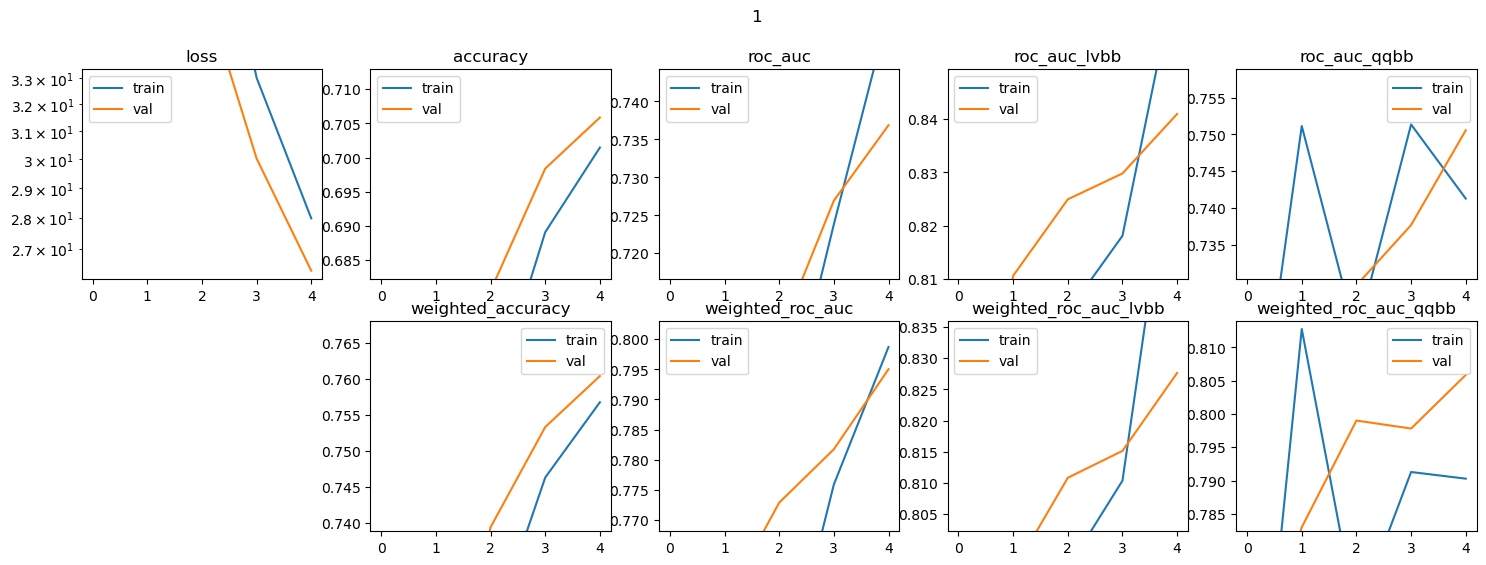

In [37]:
# Print some model training metrics
for model_num in models.keys():
    try:
        nskip = 3
        plt.figure(figsize=(18,6))
        plt.suptitle(model_num)
        totn = len([i for i in models[model_num]['history'].history.keys() if (not ('val' in i))])
        cols = (totn+1)//2
        for mn, metric in enumerate(models[model_num]['history'].history.keys()):
            # if metric == 'lr':
            #     continue
            if 'val' in metric:
                continue
            if mn >= cols:
                plt.subplot((totn-1)//cols+1,cols,mn+2)
            else:
                plt.subplot((totn-1)//cols+1,cols,mn+1)
            for split in ['train', 'val']:
                plt.plot(models[model_num]['history'].history[(split=='val')*'val_' + metric], label=split)
            ymin = 0.99*min(min(models[model_num]['history'].history[(split=='val')*'val_' + metric][nskip:] for split in ['train','val']))
            ymax = 1.01*max(max(models[model_num]['history'].history[(split=='val')*'val_' + metric][nskip:] for split in ['train','val']))
            plt.ylim([ymin,ymax])
            plt.legend()
            plt.title(metric)
            if metric == 'loss':
                plt.yscale('log')
    except:
        print("FAILED model %s" %(str(model_num)))

In [38]:
if 1: # Save the model(s)
    try:
        os.makedirs(saveDir + '/models/')
    except:
        print('Failed to make %s, probably already exists' %(saveDir + '/models/'))
    try:
        os.makedirs(saveDir + '/lwtnn_models/')
    except:
        print('Failed to make %s, probably already exists' %(saveDir + '/models/'))
    for model_name in models.keys():
        models[model_name]['model'].save(saveDir + "/models/" + str(model_name))

        h = models[model_name]['history'].history
        h_df  = pd.DataFrame(h)
        h_json_file = saveDir + "/models/" + str(model_name) + "_history.json"
        with open(h_json_file, mode='w') as f:
            h_df.to_json(f)
        model_short_name = str(model_name)
        input_layer = K.layers.Input(batch_shape=models[model_name]['model'].layers[0].input_shape)
        prev_layer = input_layer
        for layer in models[model_name]['model'].layers:
            layer._inbound_nodes = []
            prev_layer = layer(prev_layer)
        funcmodel = K.models.Model([input_layer], [prev_layer])
        # Save the architecture, in the format to be used by lwtnn for conversion
        arch = funcmodel.to_json()
        with open(saveDir + '/models/' + str(model_name) + 'architecture.json', 'w') as arch_file:
            arch_file.write(arch)
        # Save the weights, in the format to be used by lwtnn for conversion
        funcmodel.save_weights(saveDir + '/models/' + str(model_name) + 'weights.h5')
        # Save the variables, in the format to be used by lwtnn for conversion
        with open(saveDir + '/models/' + str(model_name) + 'variables.json', 'w') as f:
            f.write('{\n')
            f.write('\t"input_sequences": [],\n')
            f.write('\t"inputs": [\n')
            f.write('\t\t{\n')
            f.write('\t\t\t"name": "inputs_node",\n')
            f.write('\t\t\t"variables": [\n')
            for vn, variable_name in enumerate(models[model_name]['inputs']):
                f.write('\t\t\t\t{\n')
                f.write('\t\t\t\t\t"name": "%s",\n' %(variable_name))
                if 'scaler' in models[model_name].keys():
                    f.write('\t\t\t\t\t"offset": %e,\n' %(-models[model_name]['scaler'].mean_[vn]))
                    f.write('\t\t\t\t\t"scale": %e\n' %(1/(models[model_name]['scaler'].scale_[vn])))
                else:
                    f.write('\t\t\t\t\t"offset": %e,\n' %(-0))
                    f.write('\t\t\t\t\t"scale": %e\n' %(1))
                if vn != len(models[model_name]['inputs']) - 1:
                    f.write('\t\t\t\t},\n')
                if vn == len(models[model_name]['inputs']) - 1:
                    f.write('\t\t\t\t}\n')
            f.write('\t\t\t]\n')
            f.write('\t\t}\n')
            f.write('\t],\n')
            f.write('\t"outputs": [\n')
            f.write('\t\t{\n')
            f.write('\t\t\t"labels": [\n')
            f.write('\t\t\t\t"%s_score"\n' %(model_short_name))
            f.write('\t\t\t],\n')
            f.write('\t\t\t"name": "output_node"\n')
            f.write('\t\t}\n')
            f.write('\t]\n')
            f.write('}\n')
        print('Converting %s to lwtnn' %(str(model_name)))
        kfunc_path = '/users/baines/Code/ChargedHiggs_ProcessingForIntNote/nn_cpp_preds/lwtnn/converters/kerasfunc2json.py'
        arch_path = saveDir+'/models/'+str(model_name)+'architecture.json'
        wts_path = saveDir+'/models/'+str(model_name)+'weights.h5'
        var_path = saveDir+'/models/'+str(model_name)+'variables.json'
        lwtnn_path = saveDir+'/lwtnn_models/'+str(model_name)+'_FULLlwtnn.json'
        os.system('%s %s %s %s > %s' %(kfunc_path, arch_path, wts_path, var_path, lwtnn_path))
    # except:
    #     print("couldn't save model %s" %(model_name))

INFO:tensorflow:Assets written to: output/20240524-175210_TrainAndSaveNNsMulticlassNotebook2//models/1/assets


INFO:tensorflow:Assets written to: output/20240524-175210_TrainAndSaveNNsMulticlassNotebook2//models/1/assets


Converting 1 to lwtnn


lwtnn converter being configured for keras (v2.15).
Traceback (most recent call last):
  File "/users/baines/Code/ChargedHiggs_ProcessingForIntNote/nn_cpp_preds/lwtnn/converters/kerasfunc2json.py", line 440, in <module>
    _run()
  File "/users/baines/Code/ChargedHiggs_ProcessingForIntNote/nn_cpp_preds/lwtnn/converters/kerasfunc2json.py", line 59, in _run
    'outputs': _parse_outputs(
               ^^^^^^^^^^^^^^^
  File "/users/baines/Code/ChargedHiggs_ProcessingForIntNote/nn_cpp_preds/lwtnn/converters/kerasfunc2json.py", line 422, in _parse_outputs
    assert node.n_outputs == len(usr['labels'])
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError


# ALL OF THE BELOW IS FOR TESTING
May contain useful snippets; may contain absolute trash.

In [39]:
# Define functions with useful physics-y calculations (ie calculating things with Lorentz 4-vectors)
def GetXYZT_FromPtEtaPhiM(pt, eta, phi, m):
    x = pt*np.cos(phi)
    y = pt*np.sin(phi)
    z = pt*np.sinh(eta)
    t = (np.sqrt(x*x + y*y + z*z + m*m))*(m >= 0) + (np.sqrt(np.maximum((x*x + y*y + z*z - m*m), np.zeros(len(m)))))*(m < 0)
    return x,y,z,t

def GetM_FromXYZT(x,y,z,t):
    mag2 = t*t - (x*x + y*y + z*z)
    #print('\t' + str(mag2))
    #m = np.nan_to_num(np.sqrt(mag2)*(mag2>=0)) + np.nan_to_num(-np.sqrt(-mag2)*(mag2<0))
    #print('\t' + str(np.sqrt(mag2*(mag2>=0) + (-mag2)*(mag2<0))))
    #print('\t' + str(np.ones(len(mag2))*1*(mag2>=0) + np.ones(len(mag2))*-1*(mag2<0)))
    #m = np.sqrt(mag2*(mag2>=0) + (-mag2)*(mag2<0))*(np.ones(len(mag2))*1*(mag2>=0) + np.ones(len(mag2))*-1*(mag2<0))
    m = np.sign(mag2)*np.sqrt(abs(mag2))
    return m

def GetCombinedM(pt1, eta1, phi1, m1, pt2, eta2, phi2, m2):
    x1,y1,z1,t1 = GetXYZT_FromPtEtaPhiM(pt1, eta1, phi1, m1)
    x2,y2,z2,t2 = GetXYZT_FromPtEtaPhiM(pt2, eta2, phi2, m2)
    M = GetM_FromXYZT(x1+x2, y1+y2, z1+z2, t1+t2)
    return M

213/213 [==============================] - 3s 13ms/step
micro
0.8319212499182288
macro
0.8207784277741569
weighted
0.8180776998903129
None
[0.80433804 0.84185777 0.81613947]


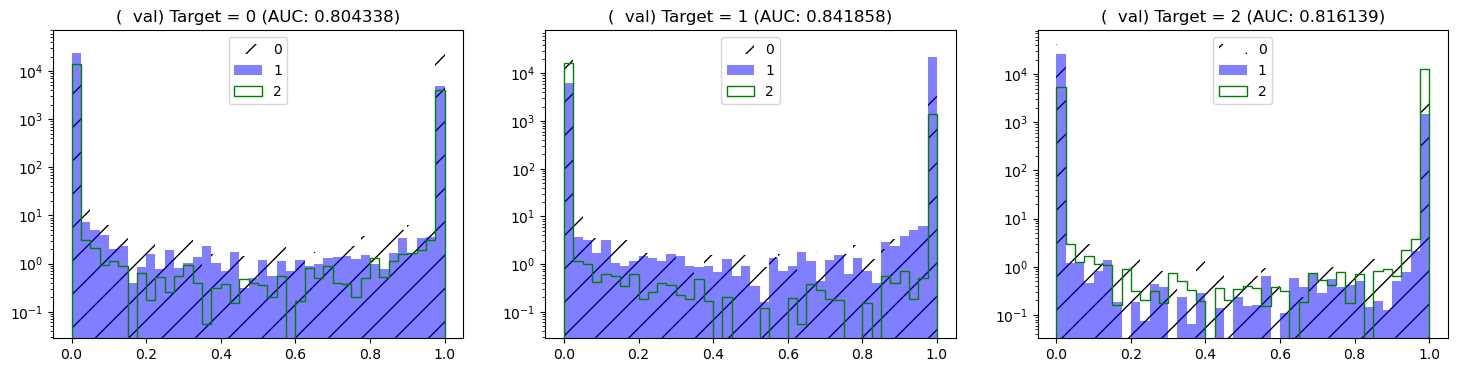

In [40]:
if 1: # Plot the model output distributions
    from sklearn.metrics import roc_auc_score
    for model_num in models.keys():
        inputs = models[model_num]['inputs']
        x_train = all_df[inputs][kfold_indices[fold_n]['train']].astype(float)
        y_train = all_df['truth'][kfold_indices[fold_n]['train']].astype(int)
        wts_train = np.abs(all_df['eventWeight'][kfold_indices[fold_n]['train']].astype(float))
        x_val = all_df[inputs][kfold_indices[fold_n]['val']].astype(float)
        y_val = all_df['truth'][kfold_indices[fold_n]['val']].astype(int)
        wts_val = np.abs(all_df['eventWeight'][kfold_indices[fold_n]['val']].astype(float))

        # Normalise the weights such that sig and background are equal
        sig_sel = (y_train != 0).astype(bool)
        wts_train[sig_sel] *= sum(wts_train[~sig_sel]) / sum(wts_train[sig_sel])# * 0.2
        sig_sel = (y_val != 0).astype(bool)
        wts_val[sig_sel] *= sum(wts_val[~sig_sel]) / sum(wts_val[sig_sel])# * 0.2
        # for set_name, x_set, y_set, wts_set in zip(['train','val'], [x_train, x_val], [y_train, y_val], [wts_train, wts_val]):
        for set_name, x_set, y_set, wts_set in zip(['val'], [x_val], [y_val], [wts_val]):
            y_out = models[model_num]['model'].predict(x_set,batch_size=4096)
            # prob_pred = tf.nn.sigmoid(y_out)
            # probs = prob_pred / np.sum(prob_pred,axis=1).reshape(-1,1)
            probs = tf.nn.softmax(y_out)
            y_pred=np.argmax(y_out,axis=1)

            for avg in ["micro", "macro", "weighted", None]:
                micro_roc_auc_ovr = roc_auc_score(
                    y_set,
                    probs,
                    sample_weight=wts_set,
                    multi_class="ovr",
                    average=avg,
                )
                print(avg)
                print(micro_roc_auc_ovr)
                # print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.5f}")
            nbins = 40
            bins=np.arange(nbins+1)/nbins
            plt.figure(figsize=(18,4))
            for target in [0,1,2]:
                plt.subplot(1,3,target+1)
                ps = probs.numpy()
                plt.hist(ps[y_set==0,target], weights=wts_set[y_set==0], bins=bins, alpha=0.0,label=0, hatch='/', facecolor=None)
                plt.hist(ps[y_set==1,target], weights=wts_set[y_set==1], bins=bins, color='b', alpha=0.5,label=1)
                plt.hist(ps[y_set==2,target], weights=wts_set[y_set==2], bins=bins, color='g', alpha=1,label=2, histtype='step')
                plt.yscale('log')
                plt.legend()
                plt.title('(%5s) Target = %d (AUC: %.6f)' %(set_name, target, micro_roc_auc_ovr[target]))
            plt.show()


# 368/368 [==============================] - 2s 6ms/step
# micro
# 0.9429171470378467
# macro
# 0.9353006866318797
# weighted
# 0.9357203977804454
# None
# [0.932385   0.94711209 0.92640496]

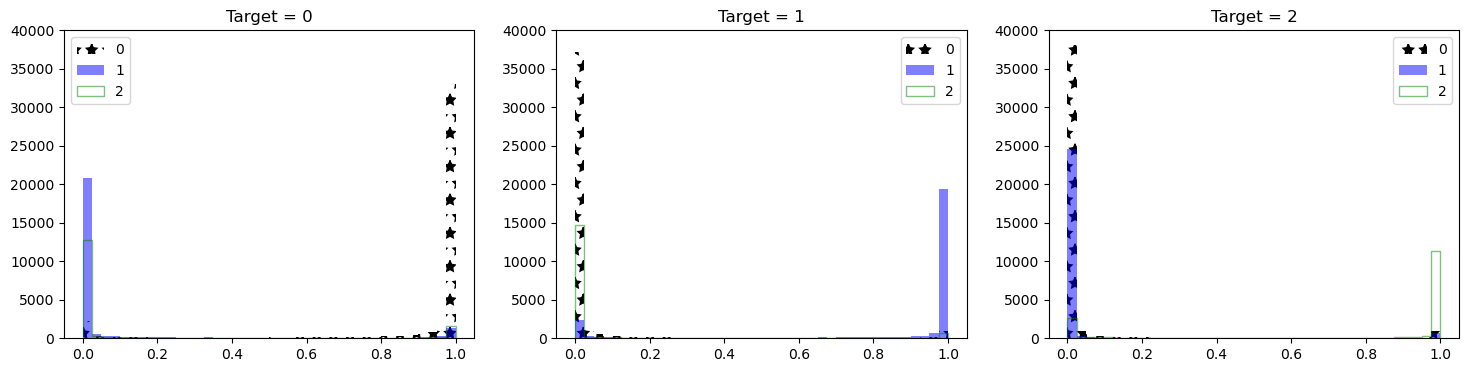

In [39]:
nbins = 40
bins=np.arange(nbins+1)/nbins
plt.figure(figsize=(18,4))
for target in [0,1,2]:
    plt.subplot(1,3,target+1)
    ps = probs.numpy()
    plt.hist(ps[y_set==0,target], weights=wts_set[y_set==0], bins=bins, alpha=0.0,label=0, hatch='*', facecolor=None)
    plt.hist(ps[y_set==1,target], weights=wts_set[y_set==1], bins=bins, color='b', alpha=0.5,label=1)
    plt.hist(ps[y_set==2,target], weights=wts_set[y_set==2], bins=bins, color='g', alpha=0.5,label=2, histtype='step')
    # plt.yscale('log')
    plt.ylim([0, 40000])
    plt.legend()
    plt.title('Target = %d' %(target))
plt.show()

In [50]:
# Make (and store!) some predictions
ts.append(time.time())
print("Time to start this cell: " + str(ts[-1] - ts[-2]))
for mod_num in [model_n]:
    mod_name = str(mod_num)
    mod = models[mod_num]['model']
    print(mod_name)
    tmp_df = all_df[models[mod_num]['inputs']][pred_sel]
    ts.append(time.time())
    print("Time to make dataset: " + str(ts[-1] - ts[-2]))
    logit_pred = mod.predict(tmp_df, verbose=1, batch_size=4096)
    ts.append(time.time())
    print("Time to make predictions: " + str(ts[-1] - ts[-2]))
    prob_pred = tf.nn.softmax(logit_pred)
    ts.append(time.time())
    print("Time to softmax predictions: " + str(ts[-1] - ts[-2]))
    y_pred = np.argmax(logit_pred,axis=1)
    for cat in [0,1,2]:
        all_df['model_%d_cat_%d'%(mod_num, cat)] = np.ones(len(all_df))*-1
        all_df.loc[pred_sel.astype(bool),'model_%d_cat_%d'%(mod_num,cat)] = prob_pred[:,cat].numpy()
    ts.append(time.time())
    print("Time to store predictions: " + str(ts[-1] - ts[-2]))

Time to start this cell: 19.304492235183716
1
Time to make dataset: 3.394742250442505
2200/2200 [==============================] - 28s 12ms/step
Time to make predictions: 39.58618426322937
Time to softmax predictions: 0.14362716674804688
Time to store predictions: 0.49138951301574707


In [120]:
truth_dict_labs = {0:'None',1:'lvbb',2:'qqbb'}
for model_num in [model_n]:
    no_pred_made = all_df['model_%d_cat_0' %(model_num)] # Is a prediction made at all? (ie was it excluded from consideration by the NN)
    threshold = 0.5
    which_sig_pred = np.argmax(all_df[['model_%d_cat_%d' %(model_num, i) for i in range(1,3)]],axis=1)+1 # If it's determined as not background, which signal
    sig_pred = np.array(~(all_df['model_%d_cat_0' %(model_num)] < threshold)).astype(int) # Is it determined as background?
    final_pred = sig_pred*which_sig_pred
    for sample_type in pd.unique(list(DSID_TYPE_MAPPING.values())):
        sample_sel = all_df['sampleType']==sample_type
        if 'H+' in sample_type:
            for truth_channel in [0, 1,2]:
                truth_sel = all_df['truth'] == truth_channel
                n_wtd = sum(all_df['eventWeight'][sample_sel & truth_sel])
                print('%30s, truth %s: %10.1f' %(sample_type, truth_dict_labs[truth_channel], n_wtd))
        else:
            n_wtd = sum(all_df['eventWeight'][sample_sel])
            print('%30s, %10.1f' %(sample_type, n_wtd))

/tmp/ipykernel_3487164/4228293953.py:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for sample_type in pd.unique(list(DSID_TYPE_MAPPING.values())):


                       Diboson,        0.0
                           Wtn,        0.0
                         ttbar,   424241.3
                    single-top,        0.0
                          4top,        0.0
                           ttV,        0.0
                     0.8TeV H+, truth None:        0.0
                     0.8TeV H+, truth lvbb:        0.0
                     0.8TeV H+, truth qqbb:        0.0
                     0.9TeV H+, truth None:        0.0
                     0.9TeV H+, truth lvbb:        0.0
                     0.9TeV H+, truth qqbb:        0.0
                     1.0TeV H+, truth None:        0.0
                     1.0TeV H+, truth lvbb:        0.0
                     1.0TeV H+, truth qqbb:        0.0
                     1.2TeV H+, truth None:        0.0
                     1.2TeV H+, truth lvbb:        0.0
                     1.2TeV H+, truth qqbb:        0.0
                     1.4TeV H+, truth None:        0.0
                     1.4TeV

In [74]:
# Prints yeilds for different selections for the old categorisation method, for some testing I'm doing on 08/03/24
truth_dict_labs = {0:'None',1:'qqbb',2:'lvbb'}
for model_num in models.keys():
    sample_types = ['0.8TeV H+','1.4TeV H+','2.0TeV H+','3.0TeV H+', 'Wjets', 'single-top', 'ttbar']
    # sample_types = pd.unique(list(DSID_TYPE_MAPPING.values()))
    print('          \t             \t',end='')
    for i in sample_types:
        print('%10s'%(i),end=',\t')
    print('')
    for category in [0,1,2,3,4,5,6,7]:
    # for category in [0,3]:
        sel_cat = all_df['selection_category'] == category
        if category == 0:
            sel_cat = sel_cat | (all_df['selection_category'] == 8) | (all_df['selection_category'] == 10) 
        if category == 3:
            sel_cat = sel_cat| (all_df['selection_category'] == 9)
        print("Category %d" %(category), end='\t')
        for truth_channel in [0,1,2]:
            print('%sTruth %5s: ' %((truth_channel>0)*"          \t", truth_dict_labs[truth_channel]), end='\t')
            for sample_type in sample_types:
                sample_sel = all_df['sampleType']==sample_type
                if 'H+' in sample_type:
                    truth_sel = all_df['truth'] == truth_channel
                    n_wtd = sum(all_df['eventWeight'][sample_sel & truth_sel & sel_cat])
                    print('%10.1f' %(n_wtd), end=', ')
                    print('\t',end='')
                elif truth_channel == 0:
                    n_wtd = sum(all_df['eventWeight'][sample_sel & sel_cat])
                    print('%10.1f' %(n_wtd), end='\t')
                else:
                    print('\t',end='')
            print('')

          	             	 0.8TeV H+,	 1.4TeV H+,	 2.0TeV H+,	 3.0TeV H+,	     Wjets,	single-top,	     ttbar,	
Category 0	Truth  None: 	    1589.6, 	    2036.5, 	    1995.3, 	    1755.1, 	    5459.4	    1886.4	   24121.0	
          	Truth  qqbb: 	    1931.8, 	    1892.5, 	    1971.3, 	    1983.8, 				
          	Truth  lvbb: 	    9423.7, 	   11904.6, 	   11117.6, 	    9764.7, 				
Category 1	Truth  None: 	     665.4, 	     822.6, 	     856.5, 	     804.5, 	    4135.0	    6364.7	  201902.5	
          	Truth  qqbb: 	    1147.4, 	    1106.4, 	     973.0, 	     977.7, 				
          	Truth  lvbb: 	    4532.9, 	    5178.4, 	    4900.3, 	    4918.9, 				
Category 2	Truth  None: 	     362.5, 	     365.7, 	     317.3, 	     363.0, 	    5482.4	    8573.5	  134933.4	
          	Truth  qqbb: 	    3388.7, 	    2507.4, 	    2444.8, 	    2307.7, 				
          	Truth  lvbb: 	    2144.1, 	    1810.3, 	    1934.2, 	    2035.3, 				
Category 3	Truth  None: 	     129.6, 	     352.3, 	     440.3, 	     52

In [54]:
# vals, bin_edges = np.histogram([all_df['model_1_cat_0'][(all_df['truth'] == truth_channel) & sample_sel] for truth_channel in range(3)], bins=bins) #, color=truth_channel
sample_sel = all_df['sampleType'] == '0.8TeV H+'
vals=np.zeros(shape=(len(bins)-1,3))
for truth_channel in [0,1,2]:
    vals[:,truth_channel], bin_edges = np.histogram(all_df['model_1_cat_0'][(all_df['truth'] == truth_channel) & sample_sel], bins=bins) #, color=truth_channel


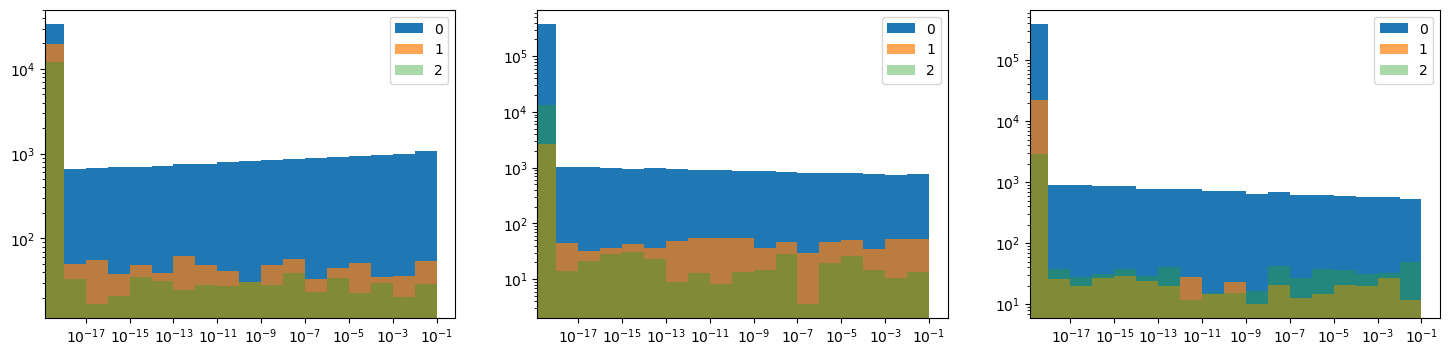

In [100]:
# Show model outputs (sometimes they get almost all pushed down to 0)
density=False
bins = 1/10**(np.arange(19,0,-1))
for model_num in [model_n]:
    plt.figure(figsize=(18,4))
    for target_num in range(3):
        plt.subplot(1,3,target_num+1)
        for truth_channel in [0,1,2]:
            plt.hist(all_df['model_%d_cat_%d' %(model_num, target_num)][all_df['truth']==truth_channel], weights=all_df['eventWeight'][all_df['truth']==truth_channel], bins=bins, label=truth_channel, density=density, alpha=1-0.3*truth_channel)
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
    plt.show()
        # bins = 1/10**(np.arange(15,0,-1))
        # for truth_channel in [0,1,2]:
        #     plt.hist(all_df['model_%d_cat_%d' %(model_num, target_num)][all_df['truth']==truth_channel], weights=all_df['eventWeight'][all_df['truth']==truth_channel], bins=bins, label=truth_channel, density=density)
        # plt.xscale('log')
        # plt.yscale('log')
        # plt.legend()
        # plt.show()

In [52]:
# Prints yeilds for different selections for the NEW categorisation method, for some testing I'm doing
truth_dict_labs = {0:'None',1:'lvbb',2:'qqbb', -1:'excl'}
for model_num in [model_n]:
    no_pred_made = all_df['model_%d_cat_0' %(model_num)] == -1 # Is a prediction made at all? (ie was it excluded from consideration by the NN)
    threshold = 1e-40
    which_sig_pred = np.argmax(all_df[['model_%d_cat_%d' %(model_num, i) for i in range(1,3)]],axis=1)+1 # If it's determined as not background, which signal
    sig_pred = np.array(~(all_df['model_%d_cat_0' %(model_num)] > threshold)).astype(int) # Is it determined as background?
    final_pred = sig_pred*which_sig_pred
    final_pred[no_pred_made] = -1
    sample_types = ['0.8TeV H+','1.4TeV H+','2.0TeV H+','3.0TeV H+', 'Wjets', 'single-top', 'ttbar']
    # sample_types = ['1.6TeV H+','ttbar']
    # sample_types = pd.unique(list(DSID_TYPE_MAPPING.values()))
    print('                                     ',end='')
    for i in sample_types:
        print('%10s'%(i),end=',     ')
    print('')
    for pred_category in [-1, 0,1,2]:
        sel_cat = final_pred == pred_category
        print("Category %s" %(truth_dict_labs[pred_category]), end='    ')
        for truth_channel in [0,1,2]:
            print('%sTruth %5s: ' %((truth_channel>0)*"                 ", truth_dict_labs[truth_channel]), end='       ')
            for sample_type in sample_types:
                sample_sel = all_df['sampleType']==sample_type
                if 'H+' in sample_type:
                    truth_sel = all_df['truth'] == truth_channel
                    n_wtd = sum(all_df['eventWeight'][sample_sel & truth_sel & sel_cat])
                    print('%10.1f' %(n_wtd), end='      ')
                elif truth_channel == 0:
                    n_wtd = sum(all_df['eventWeight'][sample_sel & sel_cat])
                    print('%10.1f' %(n_wtd), end='      ')
                else:
                    print('    ',end='')
            print('')


#                                       1.6TeV H+,          ttbar,     
# Category excl    Truth  None:               0.0             0.0      
#                  Truth  lvbb:               0.0          
#                  Truth  qqbb:               0.0          
# Category None    Truth  None:            1865.2        415872.2      
#                  Truth  lvbb:            7595.7          
#                  Truth  qqbb:            7071.8          
# Category lvbb    Truth  None:            1679.3          4733.4      
#                  Truth  lvbb:           15187.6          
#                  Truth  qqbb:             616.6          
# Category qqbb    Truth  None:             282.8          3635.8      
#                  Truth  lvbb:             560.6          
#                  Truth  qqbb:            7205.6          

                                      0.8TeV H+,      1.4TeV H+,      2.0TeV H+,      3.0TeV H+,          Wjets,     single-top,          ttbar,     
Category excl    Truth  None:               0.0             0.0             0.0             0.0             0.0             0.0             0.0      
                 Truth  lvbb:               0.0             0.0             0.0             0.0                  
                 Truth  qqbb:               0.0             0.0             0.0             0.0                  
Category None    Truth  None:            1959.3           954.3           548.6           253.2             0.0         14301.8        355386.0      
                 Truth  lvbb:           10943.0          4224.7          1808.9           671.3                  
                 Truth  qqbb:            7383.0          2923.9          1478.7           751.7                  
Category lvbb    Truth  None:             714.8          2306.0          2552.2          2417.

In [38]:
# Prints yeilds for different selections for the OLD categorisation method, for some testing I'm doing
truth_dict_labs = {0:'None',1:'qqbb',2:'lvbb'}
pred_dict_labs = {-1:'excl',3:'qqbb',0:'lvbb'}
for model_num in models.keys():
    sample_types = ['0.8TeV H+','1.4TeV H+','2.0TeV H+','3.0TeV H+', 'Wjets', 'single-top', 'ttbar']
    # sample_types = pd.unique(list(DSID_TYPE_MAPPING.values()))
    print('                                     ',end='')
    for i in sample_types:
        print('%10s'%(i),end=',     ')
    print('')
    # for category in [0,1,2,3,4,5,6,7]:
    for category in [-1,3,0]:
        sel_cat = all_df['selection_category'] == category
        if category == 0:
            sel_cat = sel_cat | (all_df['selection_category'] == 8) | (all_df['selection_category'] == 10) 
        if category == 3:
            sel_cat = sel_cat| (all_df['selection_category'] == 9)
        if category == -1:
            for other_cat in [1,2,4,5,6,7]:
                sel_cat = sel_cat | (all_df['selection_category'] == other_cat)
        print("Category %s" %(pred_dict_labs[category]), end='    ')
        for truth_channel in [0,1,2]:
            print('%sTruth %5s: ' %((truth_channel>0)*"                 ", truth_dict_labs[truth_channel]), end='       ')
            for sample_type in sample_types:
                sample_sel = all_df['sampleType']==sample_type
                if 'H+' in sample_type:
                    truth_sel = all_df['truth'] == truth_channel
                    n_wtd = sum(all_df['eventWeight'][sample_sel & truth_sel & sel_cat])
                    print('%10.1f' %(n_wtd), end='      ')
                elif truth_channel == 0:
                    n_wtd = sum(all_df['eventWeight'][sample_sel & sel_cat])
                    print('%10.1f' %(n_wtd), end='      ')
                else:
                    print('    ',end='')
            print('')

                                      0.8TeV H+,      1.4TeV H+,      2.0TeV H+,      3.0TeV H+,          Wjets,     single-top,          ttbar,     
Category excl    Truth  None:            1081.5          1362.6          1447.6          1501.2         10660.2         16241.3        354810.9      
                 Truth  qqbb:            6128.2          6424.5          6233.2          6434.3                  
                 Truth  lvbb:            7396.0          8439.4          8556.2          9177.4                  
Category lvbb    Truth  None:            1662.2          2221.1          2226.8          2000.9          5688.3          1958.1         25422.8      
                 Truth  qqbb:            2467.2          2753.6          2729.6          2511.6                  
                 Truth  lvbb:           10035.3         13253.2         12790.9         11678.9                  
Category qqbb    Truth  None:              57.0           167.7           208.9           283.

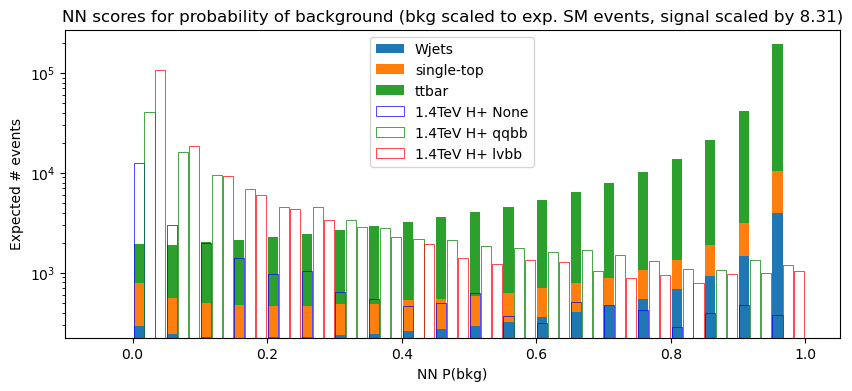

In [134]:
truth_dict_labs = {0:'None',1:'qqbb',2:'lvbb'}
import matplotlib.colors as mcolors
if 0: # Plot some histograms of the category 0 model scores (ie prob of being background) split by sample type
    import matplotlib.pyplot as plt
    nbins=20
    min_x = -1
    max_x = 1
    for sample_type in sample_types:
        sample_sel = all_df['sampleType'] == sample_type
        bins=np.arange(nbins+1)/nbins*(max_x-min_x)+min_x
        plt.figure(figsize=(10,4))
        # for truth_channel in [0,1,2]:
        #     truth_sel = all_df['truth'] == truth_channel
        #     plt.hist(all_df['model_1_cat_0'][truth_sel], label=truth_dict_labs[truth_channel]) #, color=truth_channel
        plt.hist([all_df['model_1_cat_0'][(all_df['truth'] == truth_channel) & sample_sel] for truth_channel in range(3)], bins=bins,label=['truth %s' %(truth_dict_labs[truth_channel]) for truth_channel in range(3)]) #, color=truth_channel
        plt.title(sample_type)
        plt.legend()
        plt.show()

if 1:# Now put all the backgrounds on the same graph
    plt.figure(figsize=(10,4))
    nbins=21
    min_x = -0.05
    max_x = 1
    bins=np.arange(nbins+1)/nbins*(max_x-min_x)+min_x
    n_side_by_side = 3
    prop_covered = 0.9
    bottom = np.zeros(shape=(nbins, n_side_by_side))
    for sample_type in sample_types:
        if 'H+' in sample_type:
            continue
        else:
            sample_sel = all_df['sampleType'] == sample_type
            for truth_channel in [0]:
                truth_sel = all_df['truth'] == truth_channel
                vals, bin_edges = np.histogram(all_df['model_1_cat_0'][(all_df['truth'] == truth_channel) & sample_sel], weights=all_df['eventWeight'][(all_df['truth'] == truth_channel) & sample_sel], bins=bins) #, color=truth_channel
                width = (bin_edges[1:]-bin_edges[:-1])/n_side_by_side*prop_covered
                start_pos_offset = (1-prop_covered)/(n_side_by_side+1)*(truth_channel+1)*(bin_edges[1:]-bin_edges[:-1]) + width*(truth_channel)
                plt.bar(bin_edges[:-1] + start_pos_offset, vals, width=width,align='edge',bottom=bottom[:, truth_channel],label=sample_type)
                bottom[:,truth_channel]+=vals
    tot_bkg = sum(sum(bottom))
    chosen_sig = '1.4TeV H+'
    tot_sig = sum(all_df['eventWeight'][(all_df['sampleType'] == chosen_sig)])
    for sample_type in sample_types:
        if not(chosen_sig in sample_type):
            continue
        else:
            sample_sel = all_df['sampleType'] == sample_type
            for truth_channel in [0,1,2]:
                truth_sel = all_df['truth'] == truth_channel
                vals, bin_edges = np.histogram(all_df['model_1_cat_0'][(all_df['truth'] == truth_channel) & sample_sel], weights=all_df['eventWeight'][(all_df['truth'] == truth_channel) & sample_sel], bins=bins) #, color=truth_channel
                width = (bin_edges[1:]-bin_edges[:-1])/n_side_by_side*prop_covered
                start_pos_offset = (1-prop_covered)/(n_side_by_side+1)*(truth_channel+1)*(bin_edges[1:]-bin_edges[:-1]) + width*(truth_channel)
                plt.bar(bin_edges[:-1] + start_pos_offset, vals*tot_bkg/tot_sig, fill=False, edgecolor=list(mcolors.BASE_COLORS)[truth_channel], linewidth=0.5, width=width, align='edge',bottom=0,label=sample_type + ' ' + truth_dict_labs[truth_channel])
    plt.title('NN scores for probability of background (bkg scaled to exp. SM events, signal scaled by %.2f)' %(tot_bkg/tot_sig))
    plt.legend()
    plt.xlabel('NN P(bkg)')
    plt.ylabel('Expected # events')
    plt.yscale('log')
    plt.show()

### Some shapely stuff to look at input importance

In [41]:
import shap

In [47]:
def f(X):
    # return models[1].predict([X[:, i] for i in range(X.shape[1])]).flatten()
    return models[1]['model'].predict(X)
explainer = shap.KernelExplainer(f, x_train[inputs].iloc[:50])
shap_values = explainer.shap_values(x_train[inputs].iloc[299, :], nsamples=500)
# shap.force_plot(explainer.expected_value, shap_values[0], x_val[inputs].iloc[299, :])
shap.plots.force(explainer.expected_value[0], shap_values[0])

782/782 [==============================] - 1s 2ms/step


In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], x_val[inputs].iloc[299, :])

In [49]:
shap_values50 = explainer.shap_values(x_val[inputs].iloc[280:330, :], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

782/782 [==============================] - 2s 2ms/step


In [50]:
shap.force_plot(explainer.expected_value[0], shap_values50[0], x_val[inputs].iloc[280:330, :])

In [51]:
shap.force_plot(explainer.expected_value[0], shap_values50[0], x_train[inputs].iloc[280:330, :])

In [57]:
explainer2 = shap.KernelExplainer(models[1]['model'], x_train[inputs].iloc[:200])
shap_values = explainer(x_val[:30])

  0%|          | 0/30 [00:00<?, ?it/s]

3316/3316 [==============================] - 6s 2ms/step


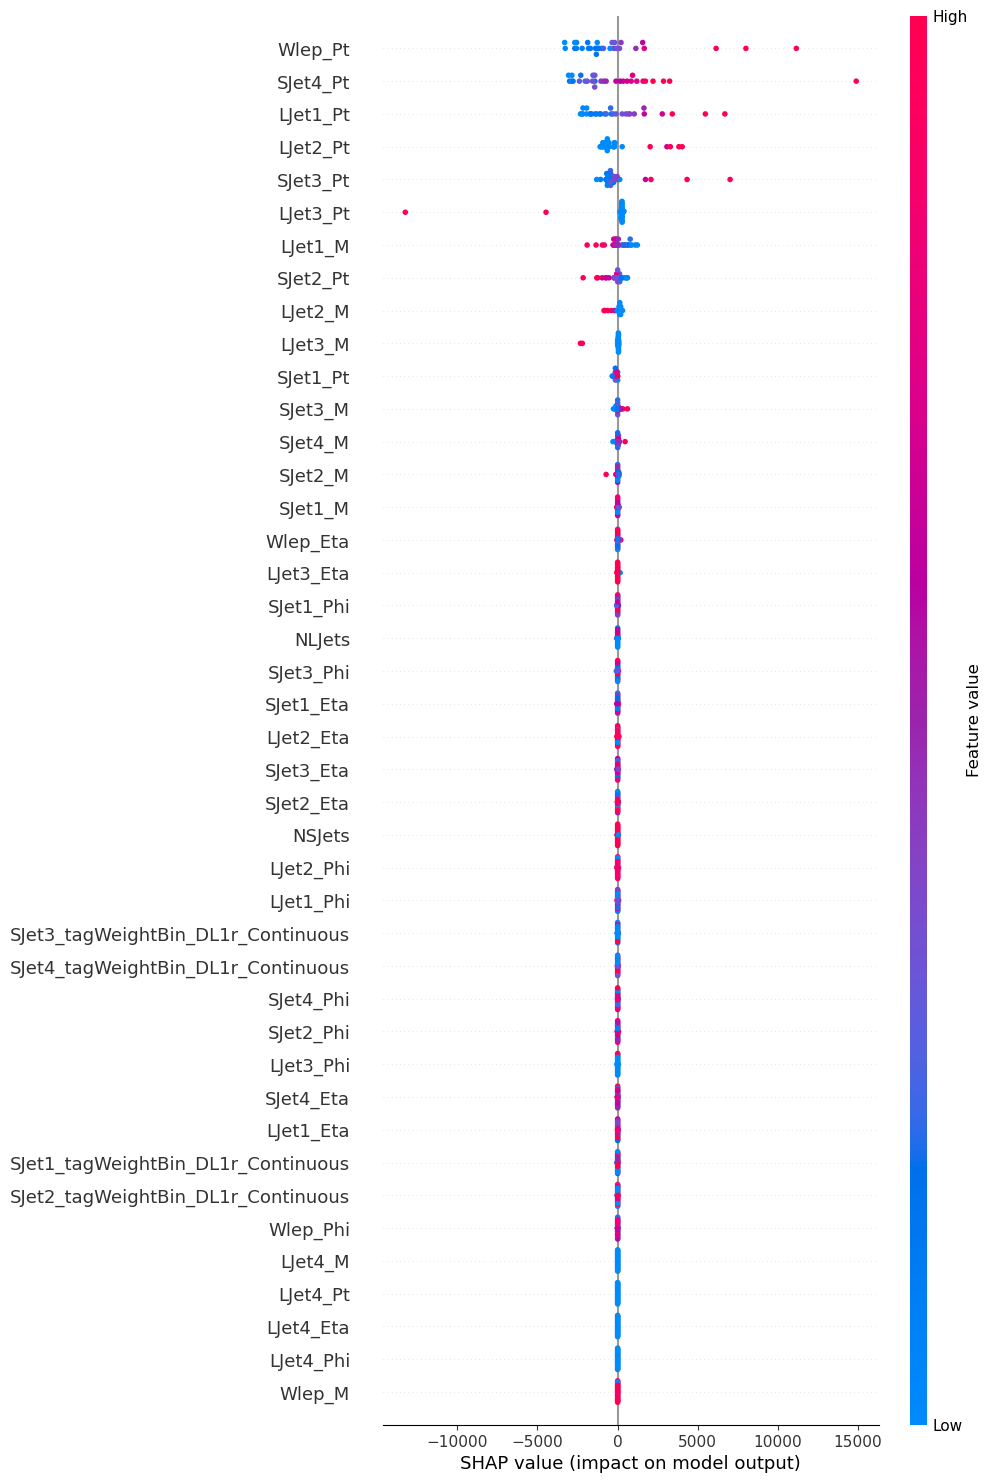

In [64]:
shap.plots.beeswarm(shap_values[:,:,0],max_display=500)

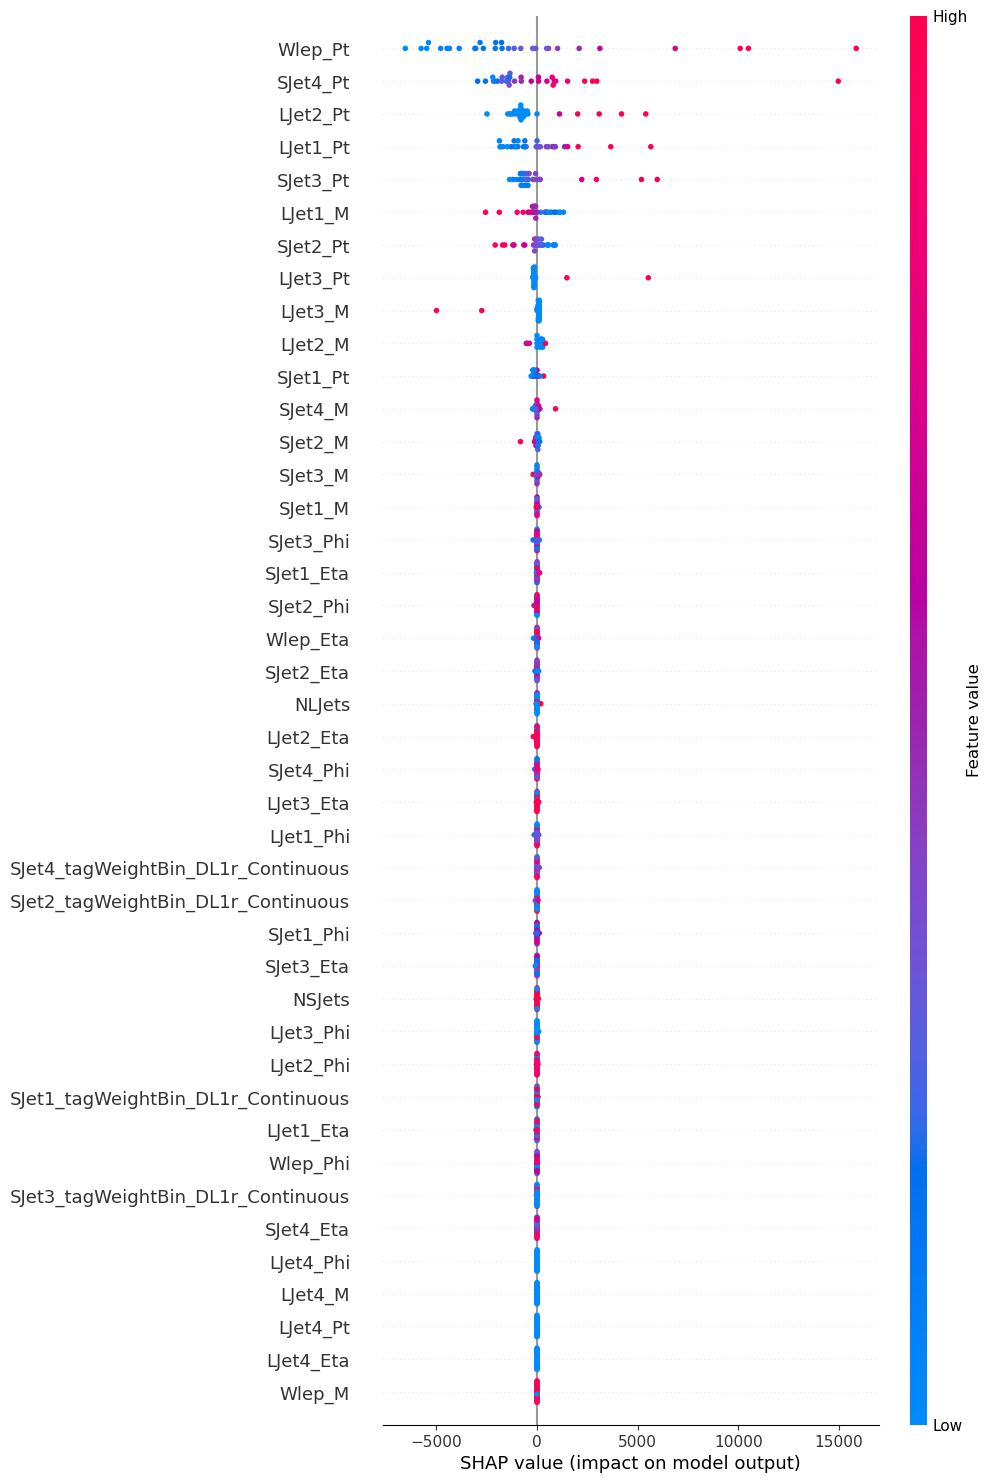

In [65]:
shap.plots.beeswarm(shap_values[:,:,1],max_display=500)

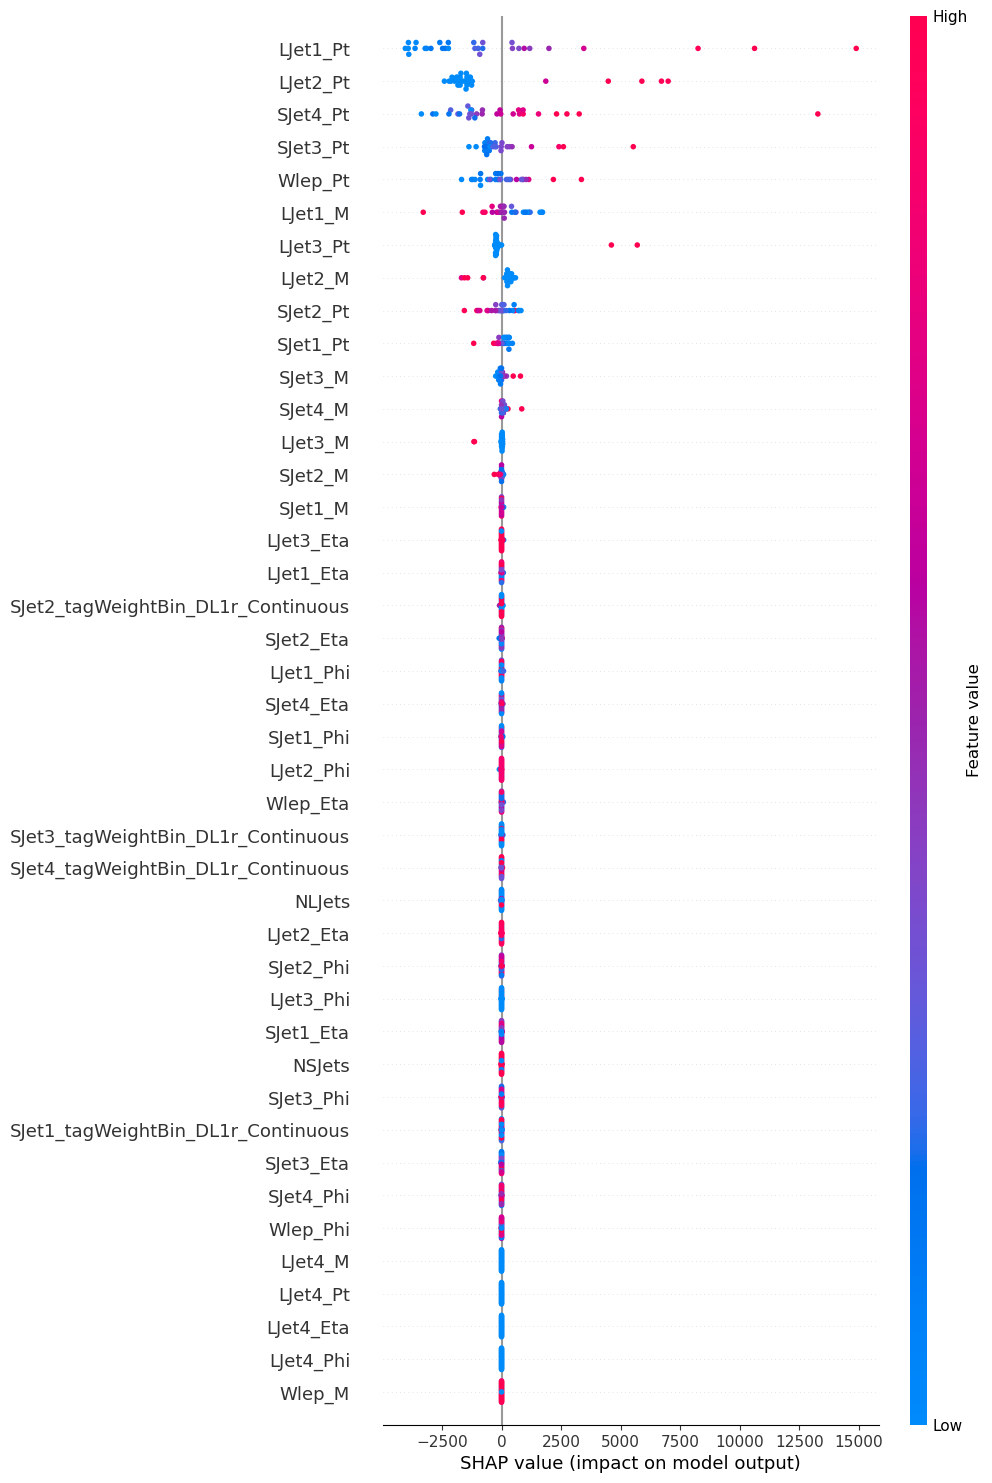

In [66]:
shap.plots.beeswarm(shap_values[:,:,2],max_display=500)

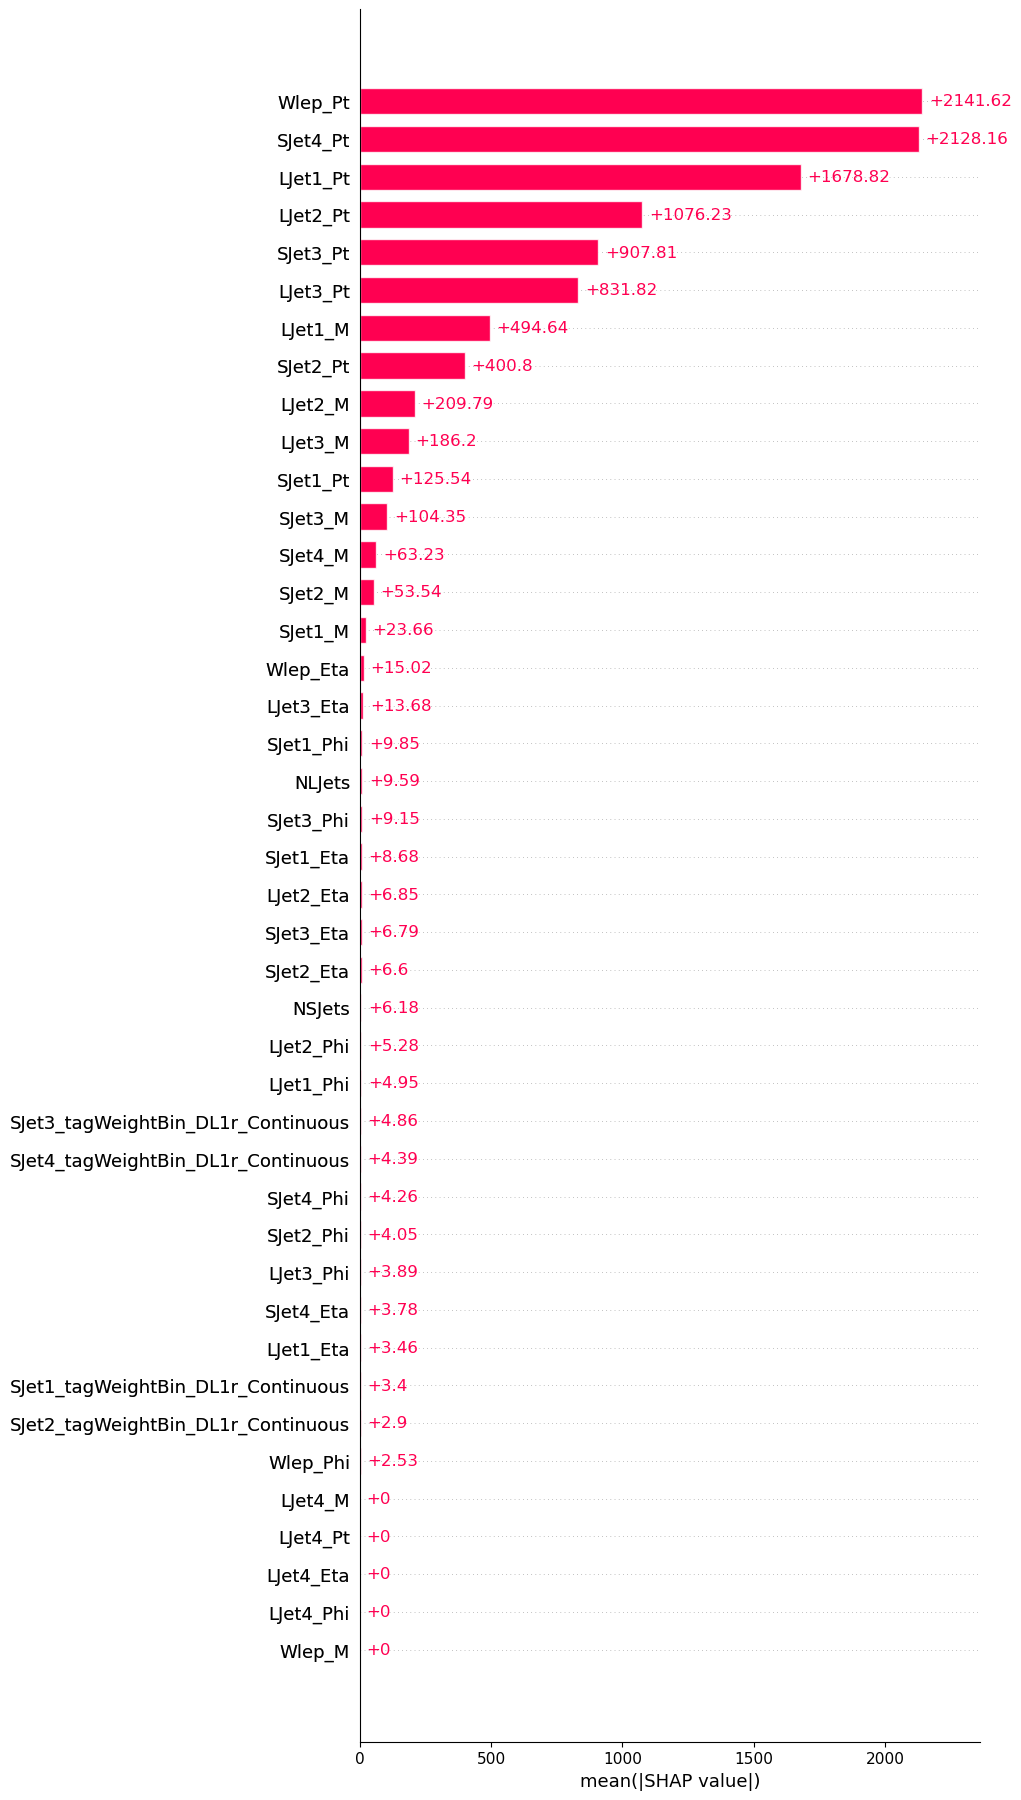

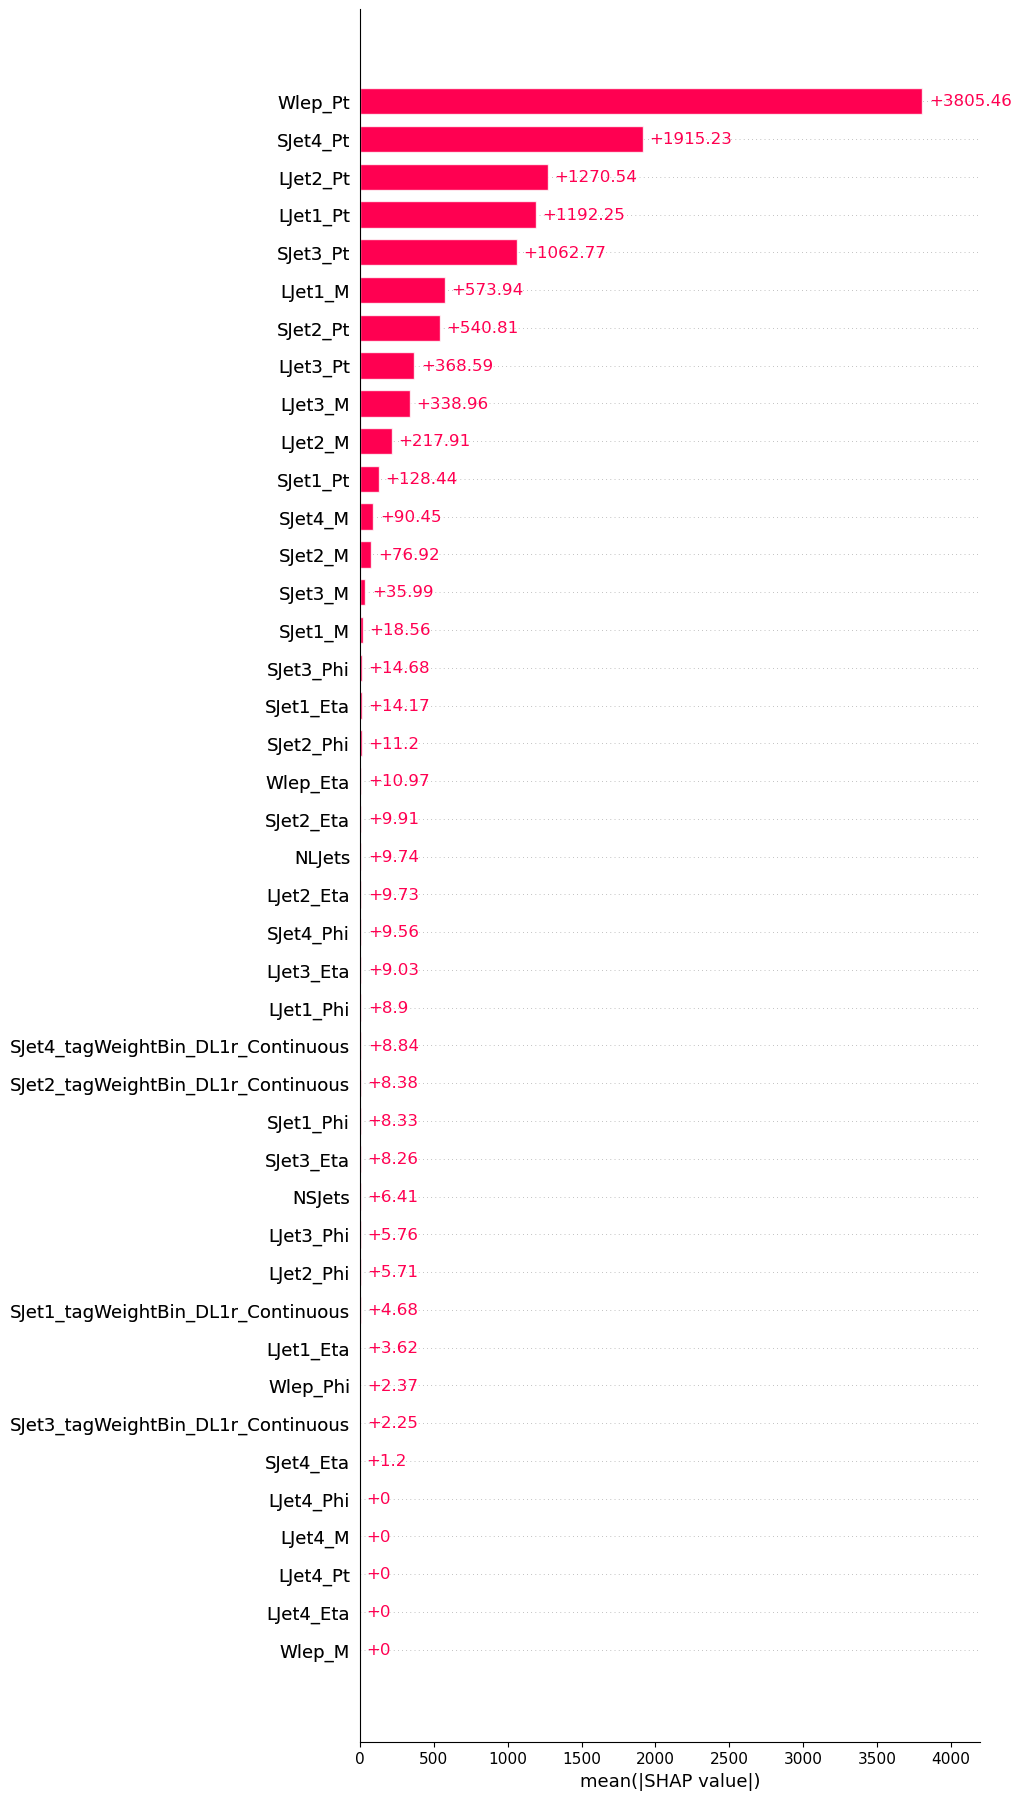

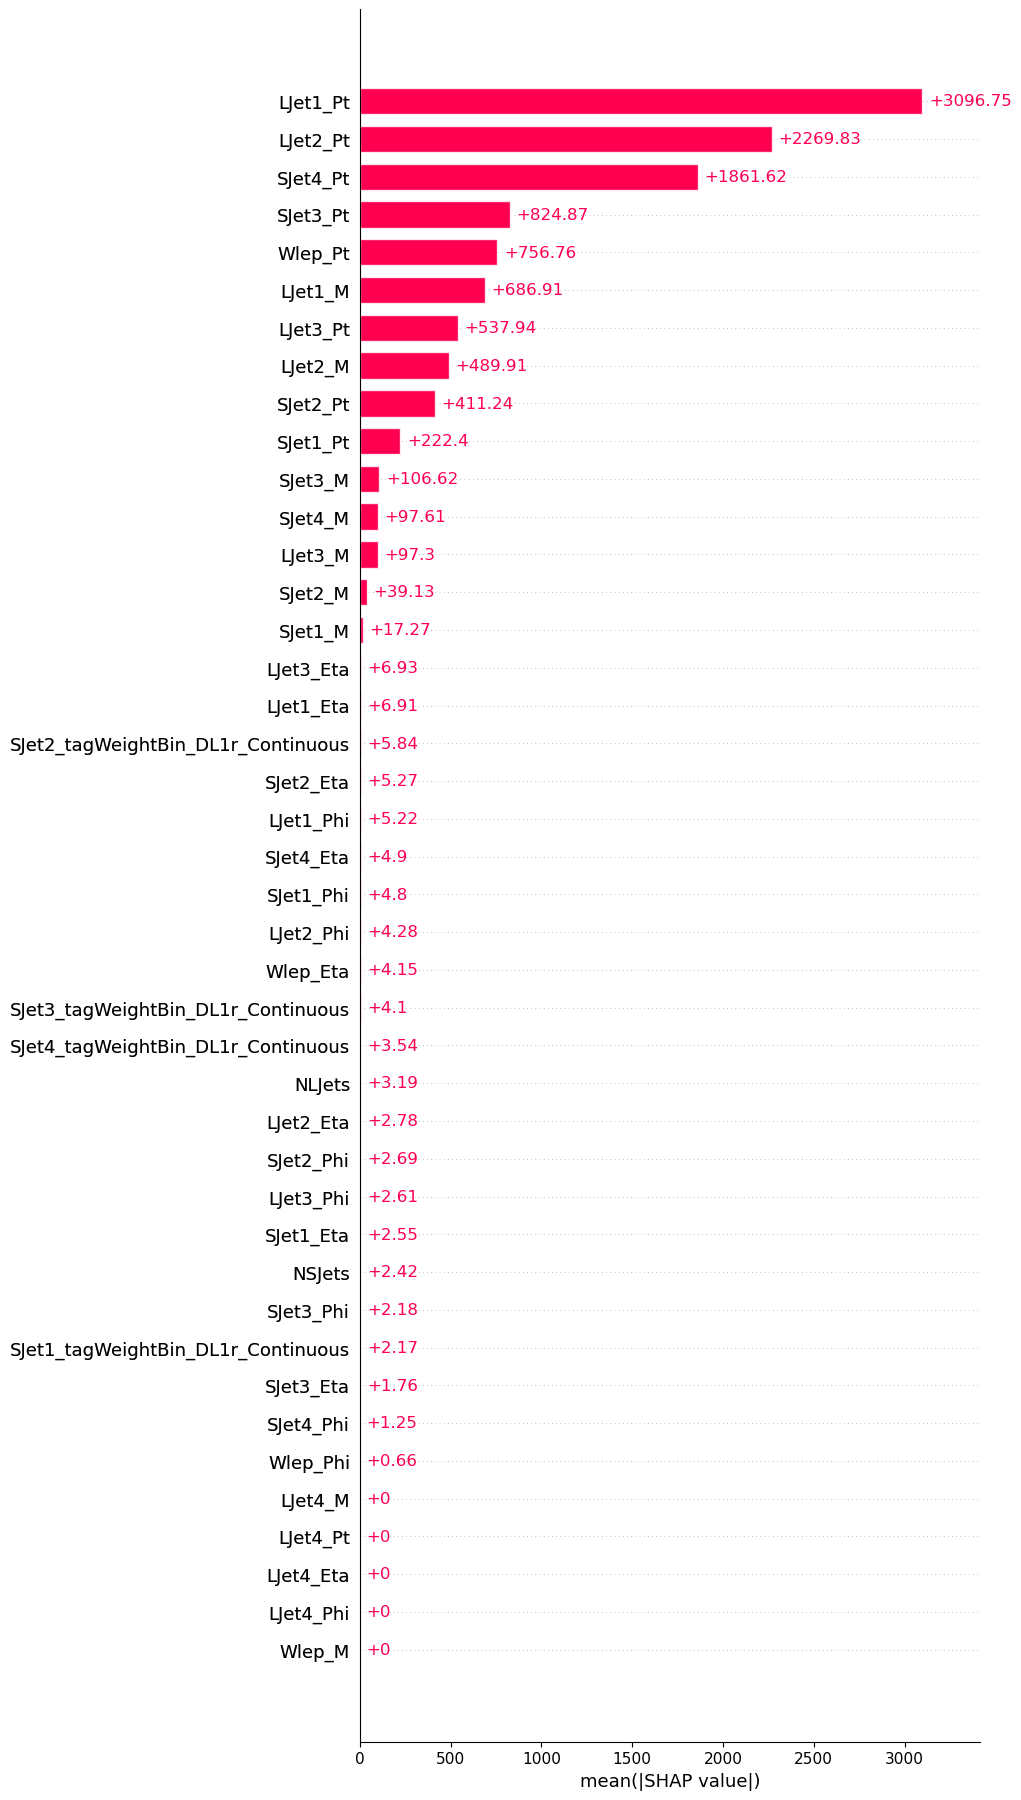

In [71]:
for target in [0,1,2]:
    shap.plots.bar(shap_values.abs.mean(0)[:,target],max_display=500)
# shap_values.abs.mean(axis=0)[:,0].shape

NameError: name 'prob_pred' is not defined

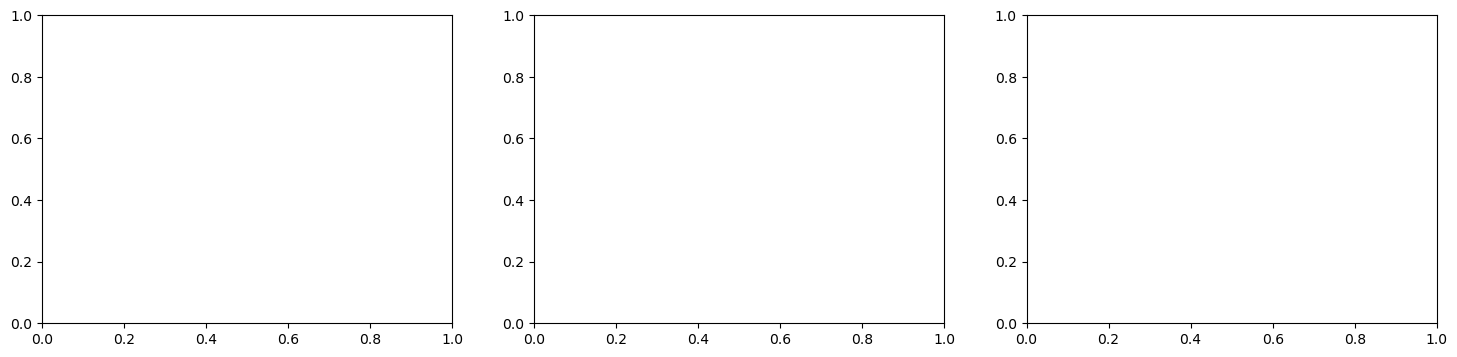

In [72]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

label_names = {0:'bkg',1:'qqbb',2:'lvbb'}
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_val = label_binarizer.transform(set_y)
y_onehot_val.shape  # (n_samples, n_classes)
fig, ax = plt.subplots(1,3,figsize=(18,4))
for class_of_interest in [0,1,2]:
    plt.subplot(1,3,class_of_interest+1)
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    # class_id
    fpr, tpr, thresholds = roc_curve(
        y_onehot_val[:, class_id],
        prob_pred[:, class_id],
        sample_weight=set_wts,
        )
    roc_auc = auc(fpr, tpr)
    plt.sca(ax[class_of_interest])
    tot_bkg = sum(set_wts[y_onehot_val[:, class_id].astype(bool)])
    plt.plot(tpr, 1/fpr, label="%s vs the rest (AUC = %.5f)" %(label_names[class_of_interest], roc_auc),color="darkorange")
    other_names = [0,1,2]
    other_names.remove(class_of_interest)
    plt.xlabel(xlabel="Signal acceptance")
    plt.ylabel(ylabel="Background rejection")
    plt.plot([0,1],[0,1], color='black', linestyle='dashed', label="Random classifier (AUC=0.5)")
    plt.legend()
    plt.yscale('log')
    plt.title("One-vs-Rest ROC curves:\n%s vs (%s & %s)" %(label_names[class_of_interest], label_names[other_names[0]], label_names[other_names[1]]))

# Now background vs all
class_of_interest = 0
plt.figure(figsize=(5,5))
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
# class_id
fpr, tpr, thresholds = roc_curve(
    1 - y_onehot_val[:, 0],
    1-prob_pred[:,0],
    sample_weight=set_wts,
    )
roc_auc = auc(fpr, tpr)
tot_bkg = sum(set_wts[y_onehot_val[:, class_id].astype(bool)])
plt.plot(tpr, 1/fpr, label="%s vs the rest (AUC = %.5f)" %(label_names[class_of_interest], roc_auc),color="darkorange")
other_names = [0,1,2]
other_names.remove(class_of_interest)
plt.xlabel(xlabel="Signal acceptance")
plt.ylabel(ylabel="Background rejection")
plt.plot([0,1],[0,1], color='black', linestyle='dashed', label="Random classifier (AUC=0.5)")
plt.legend()
plt.yscale('log')
plt.title("One-vs-Rest ROC curves:\n%s vs (%s & %s)" %(label_names[class_of_interest], label_names[other_names[0]], label_names[other_names[1]]))

In [49]:
label_binarizer.transform([])

array([[0, 0, 1]])

In [98]:
probs=tf.nn.softmax(logit_pred)
# np.argmax(probs,axis=1)
which_sig_pred = np.argmax(probs[:,1:],axis=1)+1
sig_pred = np.array(~(probs[:,0] < 0.5)).astype(int)
final_pred = sig_pred*which_sig_pred
# print(sig_pred[:20])
# print(which_sig_pred[:20])
for cat in [0,1,2]:
    truth_sel = set_y==cat
    for pred in [0,1,2]:
        pred_sel = final_pred == pred
        yld = sum(set_wts[pred_sel & truth_sel])
        print("Truth: %d, pred %d: %.2f" %(cat, pred, yld))

Truth: 0, pred 0: 30.72
Truth: 0, pred 1: 205.23
Truth: 0, pred 2: 61.51
Truth: 1, pred 0: 97.62
Truth: 1, pred 1: 16.67
Truth: 1, pred 2: 1.58
Truth: 2, pred 0: 170.56
Truth: 2, pred 1: 2.92
Truth: 2, pred 2: 8.10


1


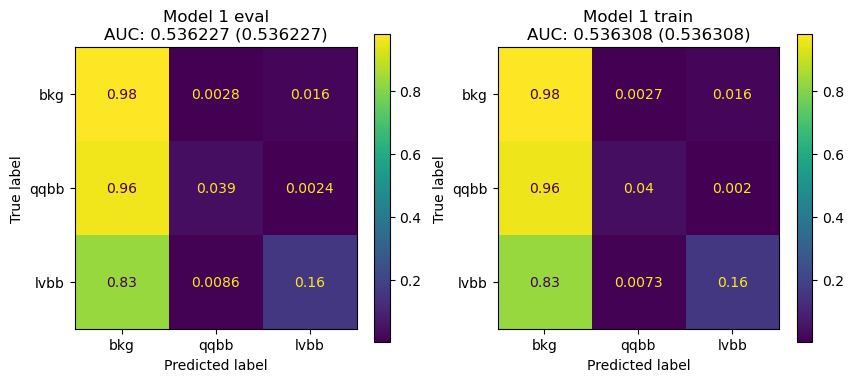

2


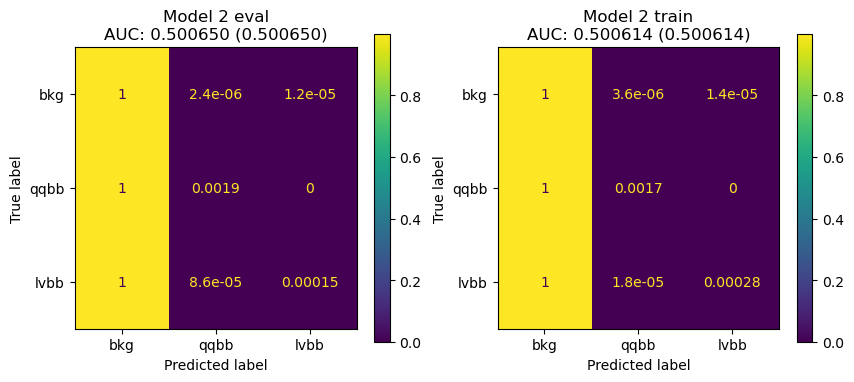

3


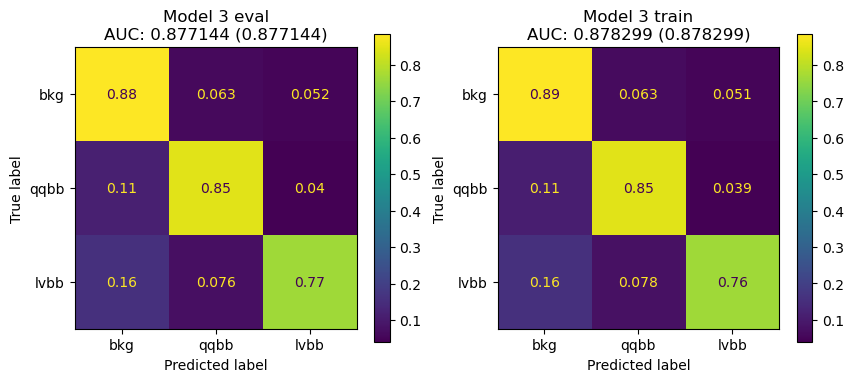

4


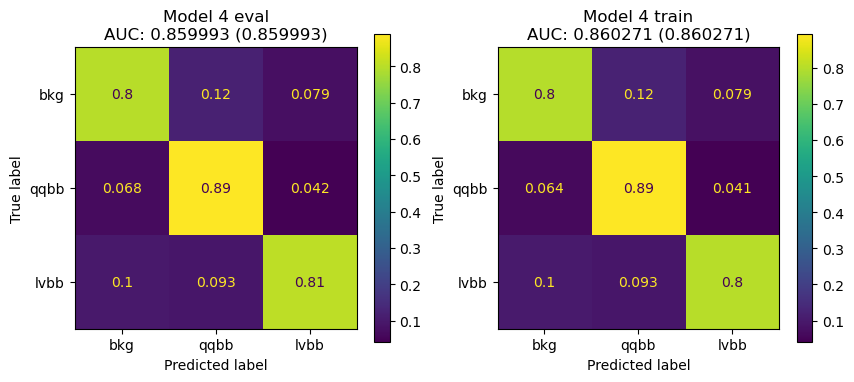

5


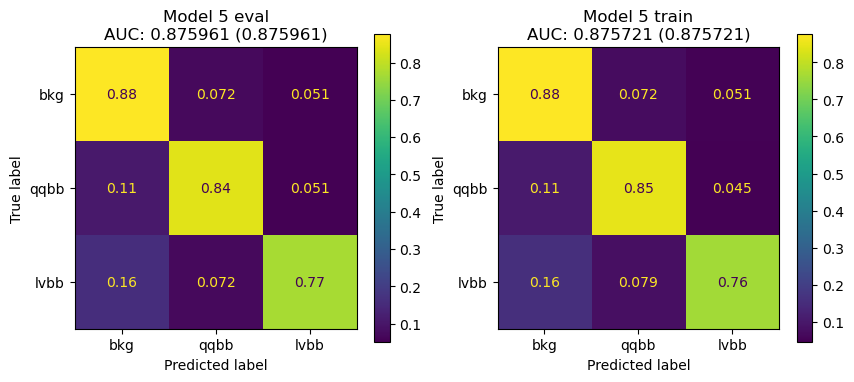

In [171]:
# Copy of above cell for a specific case where I wanted to look at results whilst i re-ran, you can delete me if you read this comment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
a=tf.keras.metrics.AUC()
# Evaluate the model on the validation dataset
# for mod_num in [list(models.keys())[0]]:
for mod_num in models.keys():
    mod_name = str(mod_num)
    mod = models[mod_num]['model']
    print(mod_name)
    # if int(mod_num) < 7:
    #     continue
    plt.figure(figsize=(10,4))
    for ax_n, set_x, set_y, set_wts, set_name in zip([1, 2], [x_val, x_train], [y_val, y_train], [wts_val, wts_train], ['eval', 'train']):
    # for ax_n, set_x, set_y, set_wts, set_name in zip([1], [x_val], [y_val], [wts_val], ['eval']):
        plt.subplot(1,2,ax_n)
        logit_pred = mod.predict(set_x, verbose=1,batch_size=4096)
        y_pred = np.argmax(logit_pred,axis=1)
        a.reset_state()
        a.update_state(set_y,y_pred)
        auc_1 = a.result()
        a.reset_state()
        a.update_state((set_y<0.5).astype(int),(y_pred<0.5).astype(int))
        auc_2 = a.result()
        cm=confusion_matrix(set_y, y_pred, sample_weight=set_wts, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bkg', 'qqbb', 'lvbb'])
        disp.plot(ax=plt.gca())
        plt.title('Model %d %s\nAUC: %f (%f)' %(mod_num, set_name, auc_1, auc_2))
    plt.show()
        # disp.show()
        # print('%s' %(mod_name))
        # print('%s accuracy: %5.2f (weighted: %5.2f)' %(set_name, test_acc*100, test_acc_wtd*100))

In [ ]:
# Copy of above cell for a specific case where I wanted to look at results whilst i re-ran, you can delete me if you read this comment
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
a=tf.keras.metrics.AUC()
# Evaluate the model on the validation dataset
# for mod_num in [list(models.keys())[0]]:
for mod_num in models.keys():
    mod_name = str(mod_num)
    mod = models[mod_num]
    print(mod_name)
    if int(mod_num) < 7:
        continue
    plt.figure(figsize=(10,4))
    for ax_n, set_x, set_y, set_wts, set_name in zip([1, 2], [x_val, x_train], [y_val, y_train], [wts_val, wts_train], ['eval', 'train']):
    # for ax_n, set_x, set_y, set_wts, set_name in zip([1], [x_val], [y_val], [wts_val], ['eval']):
        plt.subplot(1,2,ax_n)
        logit_pred = mod.predict(set_x, verbose=0)
        y_pred = np.argmax(logit_pred,axis=1)
        a.reset_state()
        a.update_state(set_y,y_pred)
        auc_1 = a.result()
        a.reset_state()
        a.update_state((set_y<0.5).astype(int),(y_pred<0.5).astype(int))
        auc_2 = a.result()
        cm=confusion_matrix(set_y, y_pred, sample_weight=set_wts, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bkg', 'qqbb', 'lvbb'])
        disp.plot(ax=plt.gca())
        plt.title('Model %d       %s AUC: %f' %(mod_num, set_name, auc_1, auc_2))
    plt.show()
        # disp.show()
        # print('%s' %(mod_name))
        # print('%s accuracy: %5.2f (weighted: %5.2f)' %(set_name, test_acc*100, test_acc_wtd*100))

: 

Index(['Wlep_M', 'Wlep_Pt', 'Wlep_Eta', 'Wlep_Phi', 'LJet1_M', 'LJet1_Pt',
       'LJet1_Eta', 'LJet1_Phi', 'LJet2_M', 'LJet2_Pt', 'LJet2_Eta',
       'LJet2_Phi', 'LJet3_M', 'LJet3_Pt', 'LJet3_Eta', 'LJet3_Phi', 'LJet4_M',
       'LJet4_Pt', 'LJet4_Eta', 'LJet4_Phi', 'SJet1_M', 'SJet1_Pt',
       'SJet1_Eta', 'SJet1_Phi', 'SJet1_tagWeightBin_DL1r_Continuous',
       'SJet2_M', 'SJet2_Pt', 'SJet2_Eta', 'SJet2_Phi',
       'SJet2_tagWeightBin_DL1r_Continuous', 'SJet3_M', 'SJet3_Pt',
       'SJet3_Eta', 'SJet3_Phi', 'SJet3_tagWeightBin_DL1r_Continuous',
       'SJet4_M', 'SJet4_Pt', 'SJet4_Eta', 'SJet4_Phi',
       'SJet4_tagWeightBin_DL1r_Continuous'],
      dtype='object')


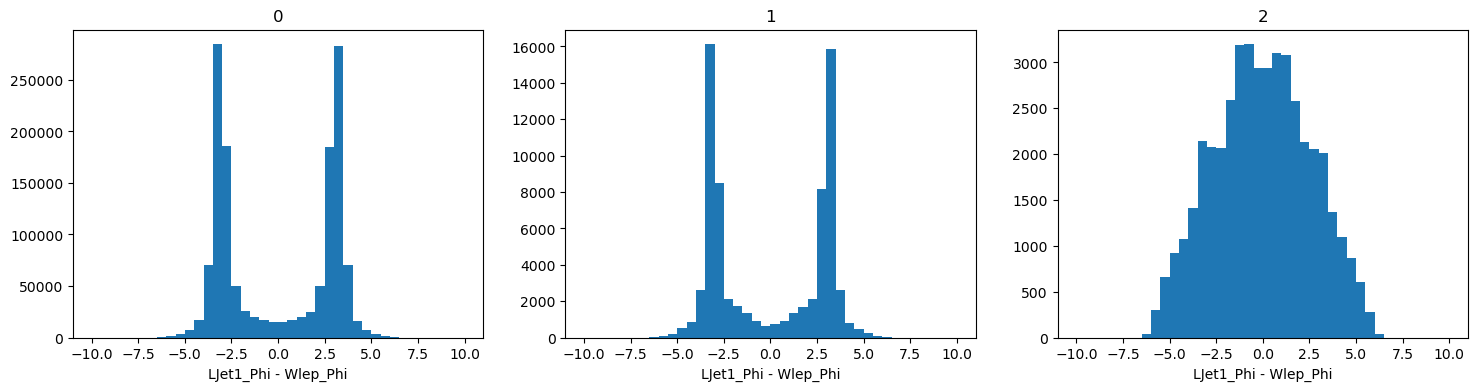

In [123]:
# Plot histogram of single variable across each target set
print(x_train.columns)
import matplotlib as mpl
nbins=40
max_eta = 10
var1='LJet1_Eta'
var1='LJet1_Phi'
# var1='LJet2_Eta'
var2='Wlep_Eta'
var2='Wlep_Phi'
bins=np.arange(nbins+1)/nbins*max_eta*2 - max_eta
plt.figure(figsize=(18,4))
for target in [0,1,2]:
    sel = (y_train==target) & (x_train[var1] != 0)
    plt.subplot(1,3,target+1)
    my_var = x_train[var1][sel] - x_train[var2][sel]
    plt.hist(my_var, bins=bins)#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
    # plt.colorbar()
    plt.xlabel(var1 + ' - ' + var2)
    plt.title(target)

Index(['Wlep_M', 'Wlep_Pt', 'Wlep_Eta', 'Wlep_Phi', 'LJet1_M', 'LJet1_Pt',
       'LJet1_Eta', 'LJet1_Phi', 'LJet2_M', 'LJet2_Pt', 'LJet2_Eta',
       'LJet2_Phi', 'LJet3_M', 'LJet3_Pt', 'LJet3_Eta', 'LJet3_Phi', 'LJet4_M',
       'LJet4_Pt', 'LJet4_Eta', 'LJet4_Phi', 'SJet1_M', 'SJet1_Pt',
       'SJet1_Eta', 'SJet1_Phi', 'SJet1_tagWeightBin_DL1r_Continuous',
       'SJet2_M', 'SJet2_Pt', 'SJet2_Eta', 'SJet2_Phi',
       'SJet2_tagWeightBin_DL1r_Continuous', 'SJet3_M', 'SJet3_Pt',
       'SJet3_Eta', 'SJet3_Phi', 'SJet3_tagWeightBin_DL1r_Continuous',
       'SJet4_M', 'SJet4_Pt', 'SJet4_Eta', 'SJet4_Phi',
       'SJet4_tagWeightBin_DL1r_Continuous'],
      dtype='object')


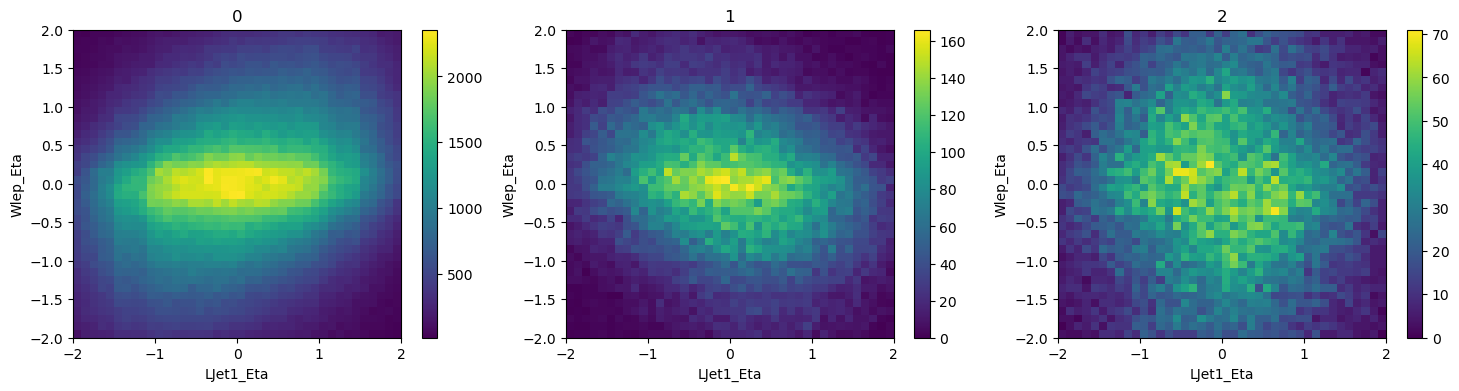

In [116]:
# Plot heatmaps of two variables across each target set
print(x_train.columns)
# plt.hist(x_train['LJet1_Eta'] - x_train['LJet2_Eta'], bins=40)
# plt.hist(x_train['LJet1_Eta'] - x_train['Wlep_Eta'], bins=100)
import matplotlib as mpl
nbins=40
max_eta = 2
var1='LJet1_Eta'
# var1='LJet2_Eta'
var2='Wlep_Eta'
bins=np.arange(nbins+1)/nbins*max_eta*2 - max_eta
plt.figure(figsize=(18,4))
for target in [0,1,2]:
    sel = (y_train==target) & (x_train[var1] != 0)
    plt.subplot(1,3,target+1)
    plt.hist2d(x_train[var1][sel], x_train[var2][sel], bins=[bins,bins])#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
    plt.colorbar()
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(target)

In [143]:
# BEGIN LATEST INTERP STUFF 
if 1: # Might need to do this for some reason, reload the model
    if 0: # Get a model from this same run of the notebook
        models[model_n+1] = {'model':tf.keras.models.load_model(saveDir + 'models/' + str(model_n), custom_objects={'ROCAUCMetric':ROCAUCMetric}),
                            'inputs': models[model_n]['inputs']}
    else: # Get another, older model. Note, you might need to have done other cells above to make this work (eg. making sure the inputs are correct, creating x_train etc.)
        inputDir = 'output/20240520-115026_TrainAndSaveNNsMulticlassNotebook2/'
        inputDir = 'output/20240521-132825_TrainAndSaveNNsMulticlassNotebook2/'
        # inputDir = 'output/20240522-143904_TrainAndSaveNNsMulticlassNotebook2/'
        model_n = 1
        # 'output/20240517-143513_TrainAndSaveNNsMulticlassNotebook2/models/'
        models[model_n+1] = {'model':tf.keras.models.load_model(inputDir + 'models/' + str(model_n), custom_objects={'ROCAUCMetric':ROCAUCMetric}),
                            'inputs': base_inputs}
    model_n+=1

In [35]:
# Create a new model which extracts the activations at each layer
if 1:
    model = models[model_n]['model']
    extractor = tf.keras.Model(inputs=model.inputs,
                            outputs=[layer.output for layer in model.layers])
    features = extractor(tf.convert_to_tensor(x_val))
    all_activs = np.concatenate([l.numpy() for l in features],axis=1)
    std_acrross_full_dataset = all_activs.std(axis=0)
    mean_acrross_full_dataset = all_activs.mean(axis=0)

testVar in [500000.00, 510000.00]
Percentage included in the test set: 1.56
Keeping 598 out of 1187 activations for consideration (removing others because less than 50.00% of the inputs had this activation non-zero)


/tmp/ipykernel_1407494/2217957379.py:68: RuntimeWarning: invalid value encountered in divide
  my_var = ((subset_activs - mean_acrross_full_dataset) / std_acrross_full_dataset).mean(axis=0)


[1186  663 1184 1127]
[0.2452823  0.22938235 0.19197287 0.19011755]


testVar in [510000.00, 520000.00]
Percentage included in the test set: 1.57
Keeping 596 out of 1187 activations for consideration (removing others because less than 50.00% of the inputs had this activation non-zero)
[1186  663 1184  622]
[0.23423451 0.21687683 0.18421948 0.16900271]


testVar in [520000.00, 530000.00]
Percentage included in the test set: 1.57
Keeping 598 out of 1187 activations for consideration (removing others because less than 50.00% of the inputs had this activation non-zero)
[ 663 1186 1184  341]
[0.21804184 0.21618536 0.16744946 0.1593099 ]




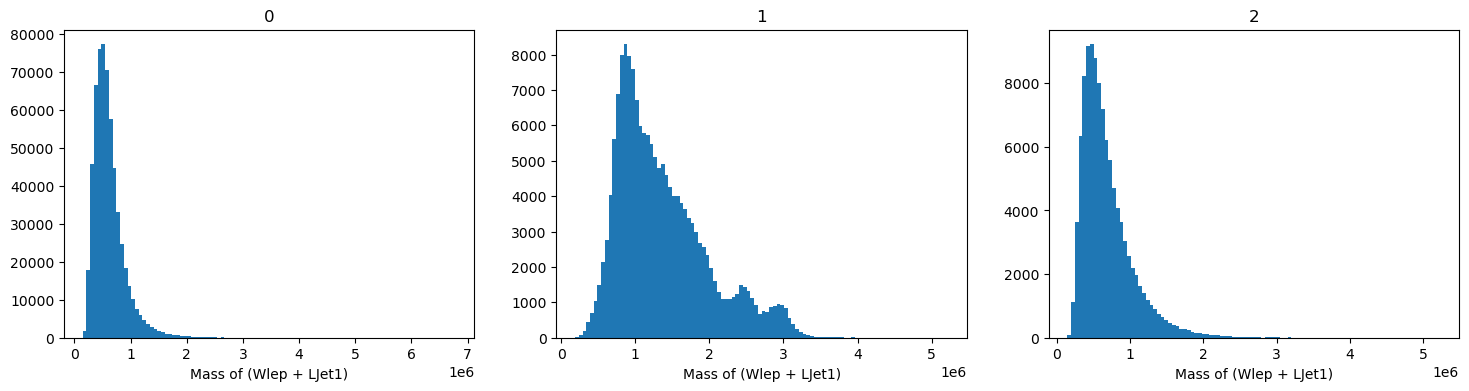

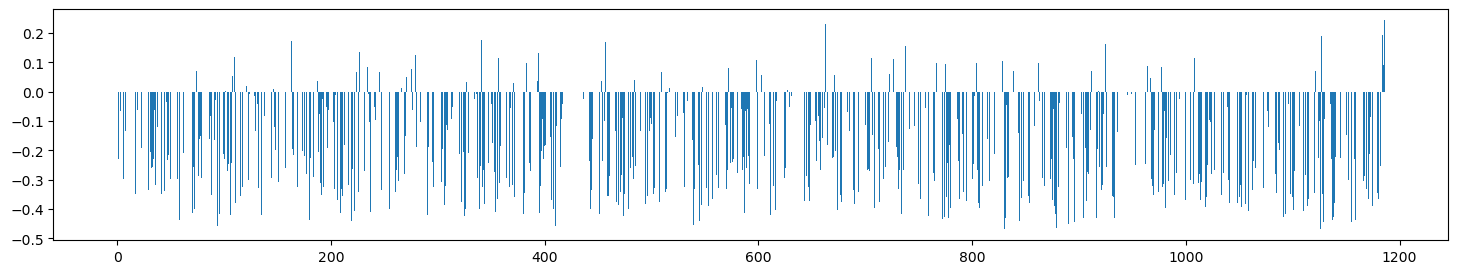

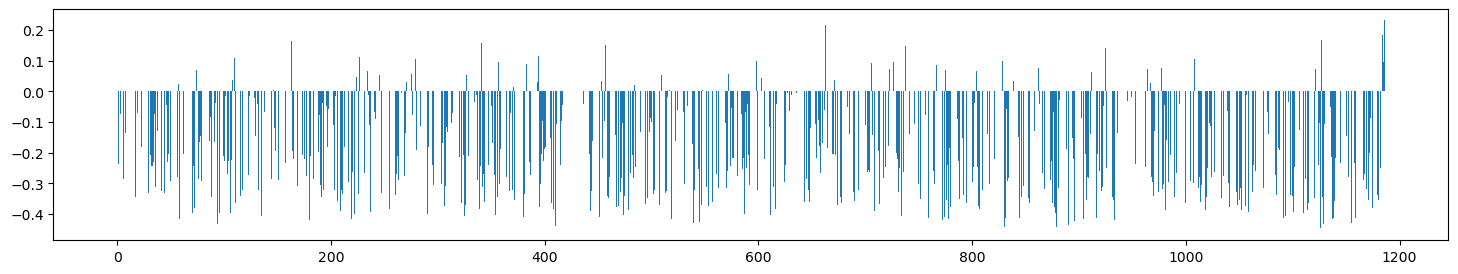

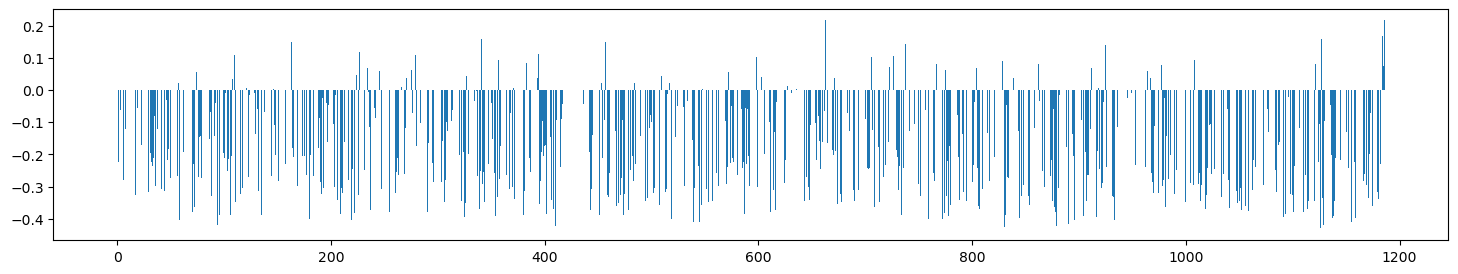

In [40]:
# Cell to select all inputs with a common physics feature and see if any activations have really high mean compared to usual mean across the set

# Select the inputs we want to run this on - all have some common high-ish-level physics feature
test_number = 1
if test_number == 0:
    var1='LJet1_Phi'
    var2='Wlep_Phi'
    max_eta = 4
    bins=np.arange(nbins+1)/nbins*max_eta*2 - max_eta
    plt.figure(figsize=(18,4))
    for target in [0,1,2]:
        sel = (y_val==target)
        plt.subplot(1,3,target+1)
        my_var = x_val[var1][sel] - x_val[var2][sel]
        plt.hist(my_var, bins=bins)#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
        # plt.colorbar()
        plt.xlabel('DeltaPhi (Wlpe, ljet1)')
        plt.title(target)
    # absDeltaPhi = abs(np.mod((x_val[var1]-x_val[var2])+np.pi, 2*np.pi)-np.pi)
    deltaPhi = np.mod(x_val[var1] - x_val[var2], np.pi*2)
    testVar = deltaPhi
    # loewrs = [3.0, 3.02, 3.04, 3.06, 3.08, 3.10, 3.12]
    lowers = [3.0, 3.02, 3.04]
    step_size = 0.02
elif test_number == 1:
    CombinedM = GetCombinedM(x_val['LJet1_Pt'], x_val['LJet1_Eta'], x_val['LJet1_Phi'], x_val['LJet1_M'], 
             x_val['Wlep_Pt'], x_val['Wlep_Eta'], x_val['Wlep_Phi'], x_val['Wlep_M'])
    bins=100
    plt.figure(figsize=(18,4))
    for target in [0,1,2]:
        sel = (y_val==target)
        plt.subplot(1,3,target+1)
        my_var = CombinedM[sel]
        plt.hist(my_var, bins=bins)#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
        # plt.colorbar()
        plt.xlabel('Mass of (Wlep + LJet1)')
        plt.title(target)
    testVar = CombinedM
    lowers = [0.5e6, 0.51e6, 0.52e6]
    step_size = 0.01e6

for lower in lowers:
    upper = lower + step_size
    print("testVar in [%.2f, %.2f]" %(lower, upper))
    sel = (testVar > lower) & (testVar < upper)
    print('Percentage included in the test set: %.2f' %(len(x_val [sel])/len(x_val)*100)) # 1.2% of events
    model = models[model_n]['model']
    extractor = tf.keras.Model(inputs=model.inputs,
                            outputs=[layer.output for layer in model.layers])
    x_tester = x_val[sel]
    features = extractor(tf.convert_to_tensor(x_tester))
    subset_activs = np.concatenate([l.numpy() for l in features],axis=1)
    # activs=np.concatenate([np.nan_to_num(l.std(axis=0)/l.mean(axis=0), nan=1000) for l in features])
    # activs=np.concatenate([np.nan_to_num(l.std(axis=0), nan=1000) for l in features])
    pct_keep = 50
    keep = (np.count_nonzero(subset_activs,axis=0) / len(subset_activs)) > pct_keep/100 # Keep only the ones where sufficient number of the activations are non-zero, because if lots are zero, then we end up with low std artificially
    print('Keeping %d out of %d activations for consideration (removing others because less than %.2f%% of the inputs had this activation non-zero)' % (sum(keep), len(keep), pct_keep))
    if 0:
        my_var = np.concatenate([l.std(axis=0) for l in features])
        my_var[~keep] = 100
        my_var = 1/my_var
    elif 0:
        my_var = np.concatenate([l.std(axis=0) for l in features]) / std_acrross_full_dataset
        my_var = np.nan_to_num(my_var, nan=1)
        my_var[~keep] = 10000 # Some value which won't flag. In this case, we say it's got a high std, because we're looking for low stds
        my_var = 1/my_var
    elif 1:
        my_var = ((subset_activs - mean_acrross_full_dataset) / std_acrross_full_dataset).mean(axis=0)
        my_var = np.nan_to_num(my_var, nan=0)
        my_var[~keep] = 0 # Some value which won't flag. In this case, we say it's got a high std, because we're looking for low stds
    # activs=np.concatenate([l.std(axis=0) for l in features])
    # [l.std(axis=0)/l.mean(axis=0) for l in features]
    # [l.std(axis=0) for l in features]
    if 1:
        plt.figure(figsize=(18,3))
        plt.bar(np.arange(len(my_var)),my_var)
    print(np.argsort(my_var)[len(my_var):-5:-1])
    print(my_var[np.argsort(my_var)[len(my_var):-5:-1]])
    print("\n")


(869276, 1187)
(869276,)
(869276, 1187)
(869276, 1)
(1187, 1)


/tmp/ipykernel_1407494/314600945.py:63: RuntimeWarning: invalid value encountered in divide
  return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))


(array([ 1.,  0.,  0.,  0.,  2.,  0.,  2.,  1.,  1.,  7.,  2.,  2.,  8.,
         1.,  9.,  3., 11.,  9.,  8., 15., 14., 14., 18., 20., 18., 40.,
        49., 87., 36., 32., 24., 20., 12., 18., 16., 14., 12., 15., 14.,
        13., 10.,  9., 14., 13.,  4., 10.,  5., 10., 10.,  8., 10.,  7.,
        14.,  4.,  7.,  7., 14., 11.,  5., 10.,  9.,  9., 12., 13.,  6.,
        17., 10., 11.,  8.,  5.,  9., 10., 16., 11., 13.,  8., 16., 10.,
        17., 11., 17., 16.,  6., 11.,  9.,  9.,  9., 10.,  9., 10., 10.,
        10.,  5.,  7.,  8.,  4.,  3.,  4.,  1.,  3.]),
 array([-0.31786804, -0.30633443, -0.29480082, -0.28326721, -0.27173359,
        -0.26019998, -0.24866637, -0.23713276, -0.22559915, -0.21406554,
        -0.20253193, -0.19099832, -0.17946471, -0.1679311 , -0.15639748,
        -0.14486387, -0.13333026, -0.12179665, -0.11026304, -0.09872943,
        -0.08719582, -0.07566221, -0.0641286 , -0.05259499, -0.04106138,
        -0.02952776, -0.01799415, -0.00646054,  0.00507307,  0.016606

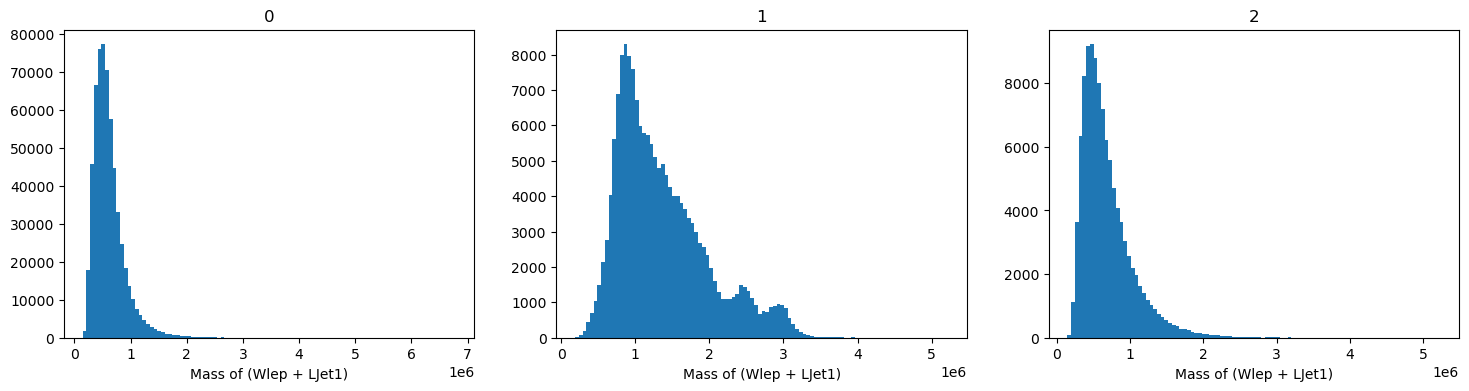

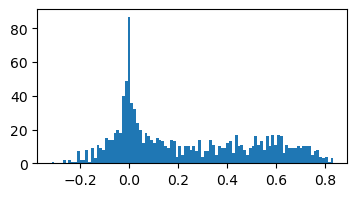

In [135]:
# TMP ISH Cell to calculate activation correlations with a common physics feature

# Select the inputs we want to run this on - all have some common high-ish-level physics feature
test_number = 2
if test_number == 0:
    var1='LJet1_Phi'
    var2='Wlep_Phi'
    max_eta = 4
    nbins = 80
    bins=np.arange(nbins+1)/nbins*max_eta*2 - max_eta
    plt.figure(figsize=(18,4))
    for target in [0,1,2]:
        sel = (y_val==target)
        plt.subplot(1,3,target+1)
        my_var = x_val[var1][sel] - x_val[var2][sel]
        plt.hist(my_var, bins=bins)#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
        # plt.colorbar()
        plt.xlabel('DeltaPhi (Wlpe, ljet1)')
        plt.title(target)
    # absDeltaPhi = abs(np.mod((x_val[var1]-x_val[var2])+np.pi, 2*np.pi)-np.pi)
    deltaPhi = np.mod(x_val[var1] - x_val[var2], np.pi*2)
    testVar = deltaPhi
elif test_number == 1:
    CombinedM = GetCombinedM(x_val['SJet1_Pt'], x_val['SJet1_Eta'], x_val['SJet1_Phi'], x_val['SJet1_M'], 
             x_val['Wlep_Pt'], x_val['Wlep_Eta'], x_val['Wlep_Phi'], x_val['Wlep_M'])
    bins=100
    plt.figure(figsize=(18,4))
    for target in [0,1,2]:
        sel = (y_val==target)
        plt.subplot(1,3,target+1)
        my_var = CombinedM[sel]
        plt.hist(my_var, bins=bins)#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
        # plt.colorbar()
        plt.xlabel('Mass of (Wlep + small-R Jet1)')
        plt.title(target)
    testVar = CombinedM
elif test_number == 2:
    CombinedM = GetCombinedM(x_val['LJet1_Pt'], x_val['LJet1_Eta'], x_val['LJet1_Phi'], x_val['LJet1_M'], 
             x_val['Wlep_Pt'], x_val['Wlep_Eta'], x_val['Wlep_Phi'], x_val['Wlep_M'])
    bins=100
    plt.figure(figsize=(18,4))
    for target in [0,1,2]:
        sel = (y_val==target)
        plt.subplot(1,3,target+1)
        my_var = CombinedM[sel]
        plt.hist(my_var, bins=bins)#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
        # plt.colorbar()
        plt.xlabel('Mass of (Wlep + large-R Jet1)')
        plt.title(target)
    testVar = CombinedM


def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
print(all_activs.shape)
print(testVar.shape)
nn = 200000
nn = len(all_activs)
a = all_activs[:nn,:]#.to_numpy()
b = testVar[:nn].to_numpy().reshape(-1,1)
print(a.shape)
print(b.shape)
c = corr2_coeff(a.T,b.T)
print(c.shape)
# plt.hist(c,bins=np.arange(41)/40)
plt.figure(figsize=(4,2))
_,_,_=plt.hist(c,bins=100)
print(c.flatten()[np.argsort(np.nan_to_num(c.flatten()))[-5:]])
print(np.argsort(np.nan_to_num(c.flatten()))[-5:])

[0.8119595  0.82066752 0.82887366 0.83438556 0.83549306]
[410 156 879  94  39]


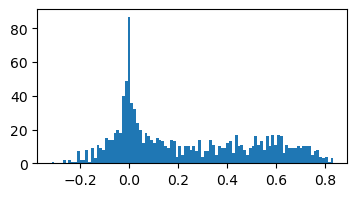

In [136]:
plt.figure(figsize=(4,2))
_,_,_=plt.hist(c,bins=100)
print(c.flatten()[np.argsort(np.nan_to_num(c.flatten()))[-5:]])
print(np.argsort(np.nan_to_num(c.flatten()))[-5:])

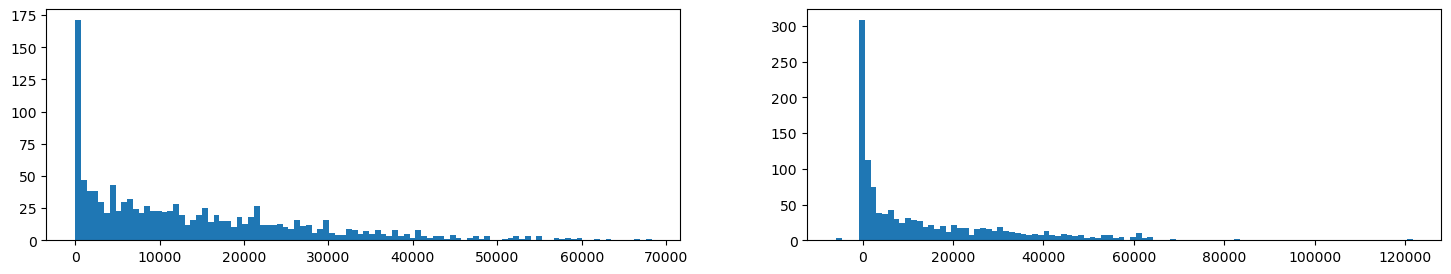

In [63]:
# std_acrross_full_dataset = all_activs.std(axis=0)
# mean_acrross_full_dataset = all_activs.mean(axis=0)
plt.figure(figsize=(18,3))
plt.subplot(1,2,1)
_,_,_=plt.hist(std_acrross_full_dataset,bins=100)
plt.subplot(1,2,2)
_,_,_=plt.hist(mean_acrross_full_dataset,bins=100)

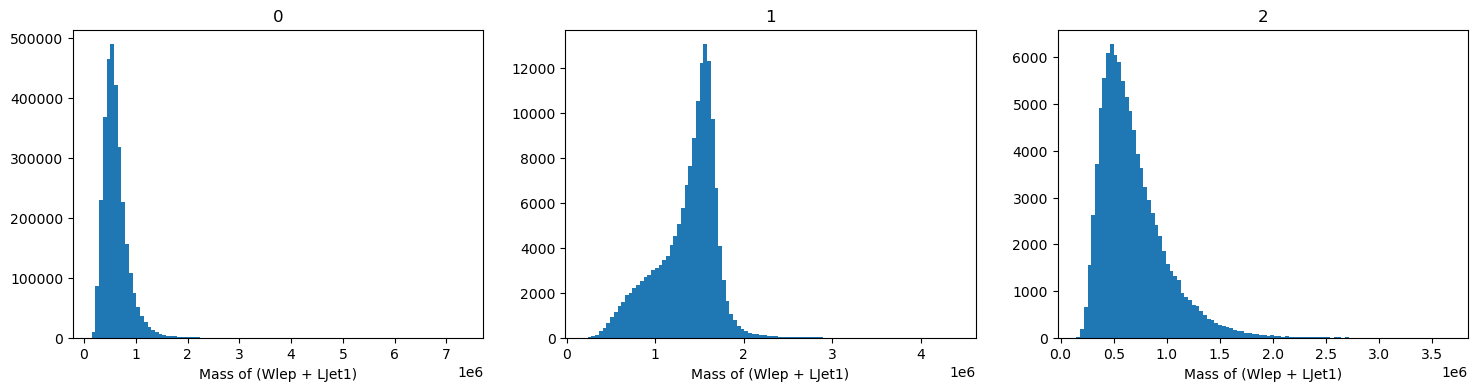

In [32]:
CombinedM = GetCombinedM(x_train['LJet1_Pt'], x_train['LJet1_Eta'], x_train['LJet1_Phi'], x_train['LJet1_M'], 
             x_train['Wlep_Pt'], x_train['Wlep_Eta'], x_train['Wlep_Phi'], x_train['Wlep_M'])
bins=100
plt.figure(figsize=(18,4))
for target in [0,1,2]:
    sel = (y_train==target)
    plt.subplot(1,3,target+1)
    my_var = CombinedM[sel]
    plt.hist(my_var, bins=bins)#,norm=mpl.colors.LogNorm())#, cmap=mpl.cm.gray)
    # plt.colorbar()
    plt.xlabel('Mass of (Wlep + LJet1)')
    plt.title(target)

[35 23 20  2]
[35 46 11  2]


/tmp/ipykernel_679387/1703766391.py:22: RuntimeWarning: invalid value encountered in divide
  my_var = np.concatenate([l.std(axis=0)/l.mean(axis=0) for l in features])


[ 862  724  523 1419]


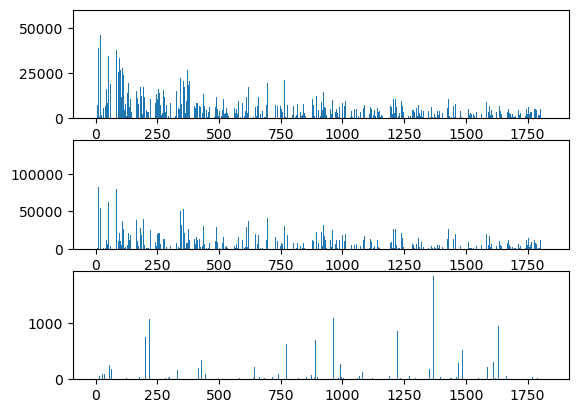

In [41]:
model = models[model_n]['model']
extractor = tf.keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
features = extractor(tf.convert_to_tensor(x_train))
features = [l.numpy() for l in features]

my_var = np.concatenate([l.std(axis=0) for l in features])
std_acrross_full_dataset = my_var
my_var[my_var == 0] = 100
plt.figure()
plt.subplot(3,1,1)
plt.bar(np.arange(len(my_var)),my_var)
print(np.argsort(my_var)[len(my_var):-5:-1])

plt.subplot(3,1,2)
my_var = np.concatenate([l.mean(axis=0) for l in features])
std_acrross_full_dataset = my_var
plt.bar(np.arange(len(my_var)),my_var)
print(np.argsort(my_var)[len(my_var):-5:-1])

plt.subplot(3,1,3)
my_var = np.concatenate([l.std(axis=0)/l.mean(axis=0) for l in features])
my_var = np.nan_to_num(my_var)
std_acrross_full_dataset = my_var
plt.bar(np.arange(len(my_var)),my_var)
print(np.argsort(my_var)[len(my_var):-5:-1])

---------------------------- m_(WLep+LJet1) in [0.58, 0.59]TeV ----------------------------
Percentage included in the test set: 2.00
Keeping 897 out of 1827 activations for consideration (removing others because less than 50.00% of the inputs had this activation non-zero)


/tmp/ipykernel_679387/2404787064.py:71: RuntimeWarning: invalid value encountered in divide
  my_var = ((np.concatenate([l for l in features],axis=1) - mean_acrross_full_dataset) / std_acrross_full_dataset).mean(axis=0)


[1005  734  774 1215]
[0.00965588 0.00943692 0.00921769 0.00902987]
---------------------------- m_(WLep+LJet1) in [0.59, 0.60]TeV ----------------------------
Percentage included in the test set: 2.00
Keeping 899 out of 1827 activations for consideration (removing others because less than 50.00% of the inputs had this activation non-zero)
[1697 1727  593  945]
[0.00916429 0.007252   0.0071324  0.0069618 ]
---------------------------- m_(WLep+LJet1) in [0.60, 0.61]TeV ----------------------------
Percentage included in the test set: 1.99
Keeping 898 out of 1827 activations for consideration (removing others because less than 50.00% of the inputs had this activation non-zero)
[1563 1657 1720  280]
[0.00777429 0.00693201 0.00690549 0.00633916]
---------------------------- m_(WLep+LJet1) in [0.61, 0.62]TeV ----------------------------
Percentage included in the test set: 1.99
Keeping 897 out of 1827 activations for consideration (removing others because less than 50.00% of the inputs had 

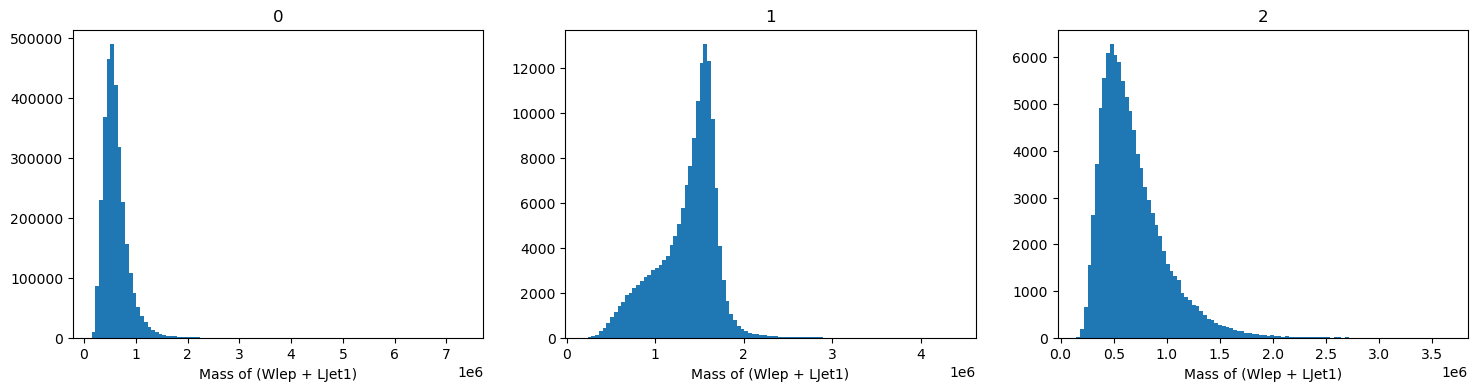

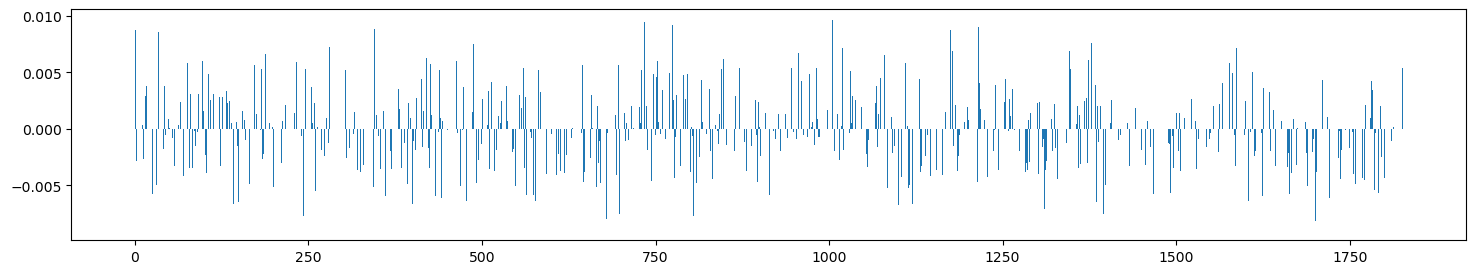

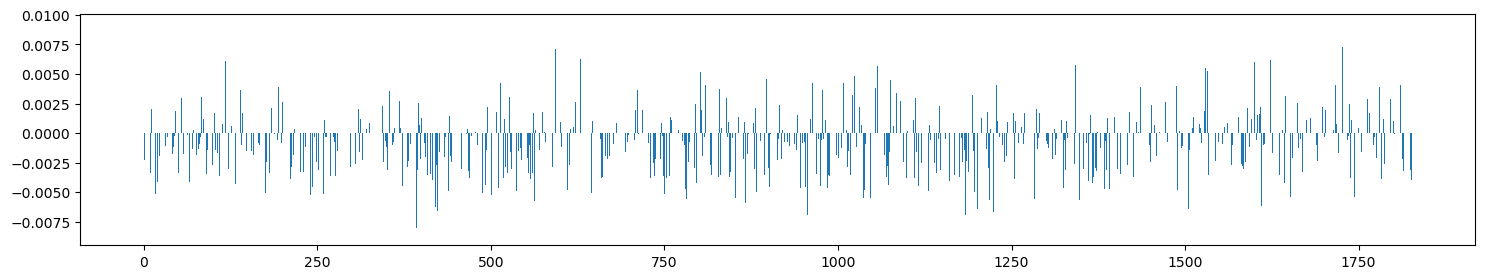

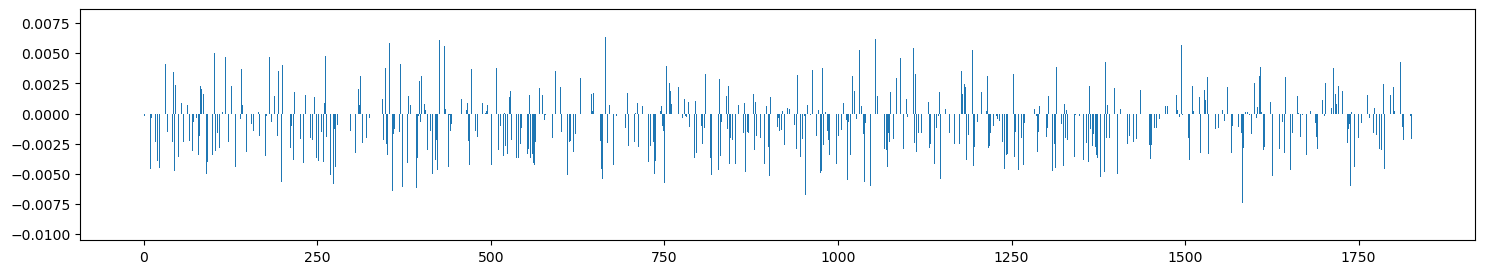

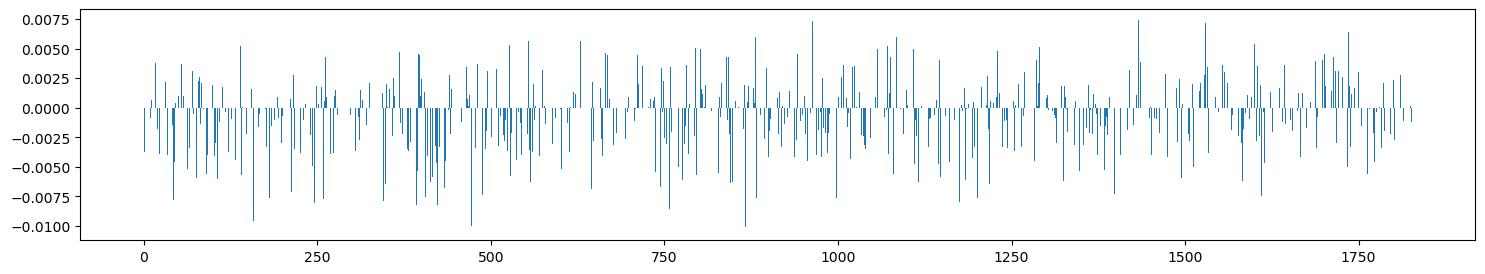

In [52]:
# Do the same as above but with random selection to get an idea

# Nede to run this only once for the cell; can cmomend out for future re-runs; takes about a minute
if 0:
    model = models[model_n]['model']
    extractor = tf.keras.Model(inputs=model.inputs,
                            outputs=[layer.output for layer in model.layers])
    features = extractor(tf.convert_to_tensor(x_train))
    features = [l.numpy() for l in features]
    my_var = np.concatenate([l.std(axis=0) for l in features])
    std_acrross_full_dataset = my_var
    mean_acrross_full_dataset = np.concatenate([l.mean(axis=0) for l in features])

for a in range(5):
    sel = np.random.rand(len(x_train)) < 0.02
    print('Percentage included in the test set: %.2f' %(len(x_train [sel])/len(x_train)*100)) # 1.2% of events
    model = models[model_n]['model']
    extractor = tf.keras.Model(inputs=model.inputs,
                            outputs=[layer.output for layer in model.layers])
    x_tester = x_train[sel]
    features = extractor(tf.convert_to_tensor(x_tester))
    features = [l.numpy() for l in features]
    keep = (np.count_nonzero(np.concatenate([l for l in features],axis=1),axis=0) / len(np.concatenate([l for l in features],axis=1))) > 0.5 # Keep only the ones where sufficient number of the activations are non-zero, because if lots are zero, then we end up with low std artificially
    print('Keeping %d out of %d activations for consideration (removing others because less than %.2f%% of the inputs had this activation non-zero)' % (sum(keep), len(keep), pct_keep))
    if 0:
        my_var = np.concatenate([l.std(axis=0) for l in features])
        my_var[~keep] = 100
        my_var = 1/my_var
    elif 0:
        my_var = np.concatenate([l.std(axis=0) for l in features]) / std_acrross_full_dataset
        my_var = np.nan_to_num(my_var, nan=1)
        my_var[~keep] = 10 # Some value which won't flag. In this case, we say it's got a high std, because we're looking for low stds
        my_var = 1/my_var
    elif 1:
        my_var = ((np.concatenate([l for l in features],axis=1) - mean_acrross_full_dataset) / std_acrross_full_dataset).mean(axis=0)
        # my_var = (np.abs((np.concatenate([l for l in features],axis=1) - mean_acrross_full_dataset) / std_acrross_full_dataset)).mean(axis=0)
        my_var = np.nan_to_num(my_var, nan=0)
        my_var[~keep] = 0 # Some value which won't flag. In this case, we say it's got a high std, because we're looking for low stds
    plt.figure(figsize=(18,3))
    plt.bar(np.arange(len(my_var)),my_var)
    print(np.argsort(my_var)[len(my_var):-5:-1])
    print(my_var[np.argsort(my_var)[len(my_var):-5:-1]])

In [54]:
# Define the neural network creation function, and the classes for hanling additional validation sets, if we are using tensorflow
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            #if epoch == 5:
            #    print('AdditionalValidationSets epoch 5 printout: valset %14s, size = %10d, bkgsize = %10d, sigsize = %10d, trues = %10d' %(validation_set_name, len(validation_targets), int(sum(~np.asarray(validation_targets).astype(bool))), int(sum(validation_targets)), int(sum(validation_targets))))
            if self.verbose > 0:
                print('epoch %3d, extra metric eval set: %20s' %(epoch, validation_set_name), end='\t') # The rest of the printout will happen in the call to evaluate
            results = self.model.evaluate(x=validation_data,
                                        y=validation_targets,
                                        verbose=self.verbose,
                                        sample_weight=sample_weights,
                                        batch_size=self.batch_size,
                                        #batch_size=len(validation_targets)
            )
            #print(sample_weights)
            """ print('results %30s of epoch %2d on set %20s: calculated using %8d samples, of which %8d were signal. Results: ' %(
                'AdditionalValidationSets',
                epoch,
                validation_set_name,
                len(validation_targets),
                sum(validation_targets),
                ),
                end='\t'
            )
            for metric, result in zip(self.model.metrics_names,results):
                print('%s=%.5f' %(metric, result), end=';\t')
            print(' ') """
            #if ((epoch==1) and (validation_set_name =='val_3.0')):
            #        print('START')
            #        #for i in validation_targets:
            #        #    print(i)
            #        print('END')
            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)




class ValidationmassSplit(tf.keras.callbacks.Callback):
    def __init__(self, input_features, truth_labels, label_mask, is_true_val_mask, verbose=0, sample_weights=None, batch_size=None):
        """
        :param input_features:
        a pandas dataframe of input features
        :param truth_labels:
        a pandas series determining the class (should be numeric, likely a list of 0s and 1s)
        :param label_mask:
        a pandas series determining the type of each sample (should be a series of strings, containing 'bkg' and then the masses of the different signal samples eg. '2.0')
        :param verbose:
        verbosity mode, 1 or 0
        :param sample_weights:
        a pandas Series of floats containing the sample weights for calculating metrics
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(ValidationmassSplit, self).__init__()
        self.validation_data = input_features
        self.validation_targets = truth_labels
        self.label_mask = label_mask
        self.sample_weights = sample_weights
        self.validation_set_names = np.setdiff1d(np.unique(self.label_mask), np.array(['bkg']))
        if not (len(self.validation_data) == len(self.validation_targets) == len(self.label_mask)):
            raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size
        self.is_true_val_mask = is_true_val_mask

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        #OTHER_TMP_THING = True
        #if not OTHER_TMP_THING:
        #    y_preds = self.model.predict(x=self.validation_data,
        #                                    verbose=self.verbose,
        #                                    batch_size=self.batch_size,
        #                                    training=False)
        #else:
        #    y_preds = self.model(self.validation_data,
        #                        training=False
        #                        )
        y_preds = self.model(self.validation_data,
                                training=False)
        for train_val_split in [0, 1]:
            if train_val_split == 0:
                val_set_type_string = 'train'
                split_mask = np.asarray(self.is_true_val_mask == 0).astype(bool)
            else:
                val_set_type_string = 'val'
                split_mask = np.asarray(self.is_true_val_mask == 1).astype(bool)
            for validation_set_name in self.validation_set_names:
                mask = (np.asarray(self.label_mask == 'bkg').astype(bool) |  np.asarray(self.label_mask == validation_set_name).astype(bool)) & split_mask
                #if epoch == 5:
                #    print('ValidationmassSplit epoch 5 printout: valset %5s %12s, size = %10d, bkgsize = %10d, sigsize = %10d, trues = %10d' %(val_set_type_string, validation_set_name, int(sum(mask)), int(sum(mask & np.asarray(self.label_mask == 'bkg').astype(bool))), int(sum(mask & np.asarray(self.label_mask == validation_set_name).astype(bool))), int(sum(self.validation_targets[mask].flatten()))))
                if self.sample_weights is not None:
                    self.model.reset_metrics()
                    self.model.compute_loss(None, 
                                        tf.convert_to_tensor(self.validation_targets[mask].flatten()), 
                                        y_preds[mask],
                                        tf.convert_to_tensor(self.sample_weights[mask].flatten())
                                    )
                    results = self.model.compute_metrics(x=None, 
                                                        y=tf.convert_to_tensor(self.validation_targets[mask].flatten()),
                                                        y_pred=y_preds[mask], 
                                                        sample_weight=tf.convert_to_tensor(self.sample_weights[mask].flatten())
                                                        )
                else:
                    self.model.reset_metrics()
                    self.model.compute_loss(None, 
                                        tf.convert_to_tensor(self.validation_targets[mask].flatten()), 
                                        y_preds[mask],
                                        None
                                    )
                    results = self.model.compute_metrics(None, 
                                                        tf.convert_to_tensor(self.validation_targets[mask].flatten()), 
                                                        y_preds[mask], 
                                                        None
                                                        )
                    #TMP_THING = False # SHOULD BE FALSE FOR REAL THING
                    #if not TMP_THING: # Method we should use for performance, I'm just trying something else for testing purposes
                    #    if not OTHER_TMP_THING:
                    #        results = self.model.compute_metrics(None, 
                    #                                            tf.convert_to_tensor(self.validation_targets[mask].flatten()), 
                    #                                            tf.convert_to_tensor(y_preds[mask].flatten()), 
                    #                                            None
                    #                                            )
                    #    else:
                    #        self.model.compute_loss(None, 
                    #                            tf.convert_to_tensor(self.validation_targets[mask].flatten()), 
                    #                            y_preds[mask],
                    #                            None
                    #                        )
                    #        results = self.model.compute_metrics(None, 
                    #                                            tf.convert_to_tensor(self.validation_targets[mask].flatten()), 
                    #                                            y_preds[mask], 
                    #                                            None
                    #                                            )
                    #else:
                    #    results = self.model.evaluate(x=self.validation_data[mask],
                    #                                y=self.validation_targets[mask],
                    #                                verbose=self.verbose,
                    #                                batch_size=self.batch_size,
                    #                                #batch_size=len(validation_targets)
                    #    )
                #print(self.sample_weights)
                #if ((epoch==1) and (validation_set_name =='3.0') and (val_set_type_string == 'val')):
                #    print('START')
                #    #for i in self.validation_targets[mask].flatten():
                #    #    print(i)
                #    print('END')
                #if not TMP_THING:
                #    for metric_name in results.keys():
                #        print('%s=%.5f' %(metric_name, results[metric_name]), end=';\t')
                #else:
                #    for metric, result in zip(self.model.metrics_names,results):
                #        print('%s=%.5f' %(metric, result), end=';\t')
                #print(' ')
                #for metric, result in zip(self.model.metrics_names,results):
                if self.verbose > 0:
                    print('Epoch %d;\t Extra validation set %10s; Results:' %(epoch, val_set_type_string + '_' + validation_set_name, ), end='\t')
                    for metric_name in results.keys():
                        print('%s=%.5f' %(metric_name, results[metric_name]), end=';\t')
                    print(' ')
                
                """ print('results %30s of epoch %2d on set %20s: calculated using %8d samples, of which %8d were signal. Results: ' %(
                    'ValidationmassSplit',
                    epoch,
                    val_set_type_string + '_' + validation_set_name,
                    len(self.validation_targets[mask].flatten()),
                    sum(self.validation_targets[mask].flatten()),
                    ),
                    end='\t'
                )
                for metric_name in results.keys():
                    print('%s=%.5f' %(metric_name, results[metric_name]), end=';\t')
                print(' ') """
                #if not TMP_THING:
                #    for metric_name in results.keys():
                #        valuename = val_set_type_string + '_' + validation_set_name + '_' + metric_name
                #        self.history.setdefault(valuename, []).append(results[metric_name])
                #else:
                #    for metric, result in zip(self.model.metrics_names,results):
                #        valuename = val_set_type_string + '_' + validation_set_name + '_' + metric
                #        self.history.setdefault(valuename, []).append(result)
                for metric_name in results.keys():
                    valuename = val_set_type_string + '_' + validation_set_name + '_' + metric_name
                    self.history.setdefault(valuename, []).append(results[metric_name])
                    



def make_standard_nn(n_inputs, layers, learning_rate, val_sets, val_set_info, patience, batch_size=128):
    # Set up model and it's layers (2x hidden layers, with a dropout between)
    model = K.Sequential()
    hidden_counter=0
    for layer in layers:
        if (layer['type'] == 'dense') and ('l1' in layer) and ('l2' in layer):
            model.add(K.layers.Dense(layer['nodes'], activation=layer['activation'], name="hidden"+str(hidden_counter), kernel_regularizer=tf.keras.regularizers.L1L2(l1=layer['l1'], l2=layer['l2'])))
            hidden_counter+=1
        elif (layer['type'] == 'dense') and ('l1' in layer) and (not 'l2' in layer):
            model.add(K.layers.Dense(layer['nodes'], activation=layer['activation'], name="hidden"+str(hidden_counter), kernel_regularizer=tf.keras.regularizers.L1(l1=layer['l1'])))
            hidden_counter+=1
        elif (layer['type'] == 'dense') and (not 'l1' in layer) and ('l2' in layer):
            model.add(K.layers.Dense(layer['nodes'], activation=layer['activation'], name="hidden"+str(hidden_counter), kernel_regularizer=tf.keras.regularizers.L2(l2=layer['l2'])))
            hidden_counter+=1
        elif (layer['type'] == 'dense') and (not 'l1' in layer) and (not 'l2' in layer):
            model.add(K.layers.Dense(layer['nodes'], activation=layer['activation'], name="hidden"+str(hidden_counter)))
            hidden_counter+=1
        elif (layer['type'] == 'dropout'):
            model.add(K.layers.Dropout(layer['proportion']))
    model.add(K.layers.Dense(3, name="output"))
    # model.add(K.layers.Dense(1, activation="sigmoid", name="output"))
    # Compile the model with Adam optimizer
    model.compile(
        optimizer=K.optimizers.Adam(learning_rate=learning_rate),
        loss=K.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[#K.metrics.BinaryAccuracy(name='accuracy'),
                    #K.metrics.TruePositives(name='tp'),
                    #K.metrics.FalsePositives(name='fp'),
                    #K.metrics.TrueNegatives(name='tn'),
                    #K.metrics.FalseNegatives(name='fn'), 
                    #K.metrics.Precision(name='precision'),
                    #K.metrics.Recall(name='recall'),
                    K.metrics.AUC(name='auc',from_logits=True),
                    K.metrics.AUC(name='prc', curve='PR',from_logits=True), # precision-recall curve
                    #K.metrics.PrecisionAtRecall(0.92, num_thresholds=200, name="MyMetrix")
                ],
        weighted_metrics=[#K.metrics.BinaryAccuracy(name='accuracy'),
                    #K.metrics.TruePositives(name='tp'),
                    #K.metrics.FalsePositives(name='fp'),
                    #K.metrics.TrueNegatives(name='tn'),
                    #K.metrics.FalseNegatives(name='fn'), 
                    #K.metrics.Precision(name='precision'),
                    #K.metrics.Recall(name='recall'),
                    K.metrics.AUC(name='auc',from_logits=True),
                    K.metrics.AUC(name='prc', curve='PR',from_logits=True), # precision-recall curve
                    #K.metrics.PrecisionAtRecall(0.92, num_thresholds=200, name="MyMetrix")
                ],
    )
    # Now create some callbacks
    # Saving best model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "model.h5", 
        monitor = "val_auc", 
        verbose = 2, 
        save_best_only = True,
        mode = 'max'
        )
    # early stopping - prevents overstopping, lr_scheduler, tensorboard_callback]fitting
    # it stops the training if your model stops improving for specified number of epochs
    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # we monitor the loss for the validation 
        min_delta=0, # minimum change in the monitored quantity to qualify as an improvement
        patience=patience, # Number of epochs with no improvement after which training will be stopped.
        verbose=2, # how verbal the description should be
        mode='min', # In min mode, training will stop when the quantity monitored has stopped decreasing
        baseline=None, # Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
        restore_best_weights=True # Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
    )
    # At the beginning of every epoch, this callback gets the updated learning rate value from scheduler function 
    def scheduler(epoch, lr):
        if epoch < 5:
            return lr
        else:
            return lr * tf.math.exp(-0.001)
            #return lr
    lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)
    # TensorBoard is a visualization tool provided with TensorFlow.
    # This callback logs events for TensorBoard, including:
    # Metrics summary plots
    # Training graph visualization
    # Weight histograms
    # Sampled profiling
    logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    if EXTRA_VALSETS_CALLBACK:# include callback for extra validation sets
        if (val_set_info == None) and (val_sets is not None):
            history = AdditionalValidationSets(val_sets, verbose=0, batch_size=batch_size)
            callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback, history]
        elif (val_sets == None) and (val_set_info is not None):
            history = ValidationmassSplit(val_set_info[0], val_set_info[1], val_set_info[2], val_set_info[4], verbose=0, sample_weights=val_set_info[3], batch_size=batch_size)
            callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback, history]
        else:
            assert(0) # You have the EXTRA_VALSETS_CALLBACK flag on, and either the you have given neither of val_set_info/val_sets, or you have given both. You cannot do this (I used to do it for testing, but never want to do this in the real runs)
            #history = AdditionalValidationSets(val_sets, verbose=2, batch_size=batch_size)
            #history2 = ValidationmassSplit(val_set_info[0], val_set_info[1], val_set_info[2], val_set_info[4], verbose=2, sample_weights=val_set_info[3], batch_size=batch_size)
            #callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback, history, history2]
        # collecting all callbacks together
        
    else:
        # collecting all callbacks together
        callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback]
    return model, callbacks_list


